## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### Model is in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [13]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-06-16 01:08:48--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.46.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.46.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  58.8MB/s    in 5.4s    

2020-06-16 01:08:54 (60.2 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Haki

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [14]:
# install this awesome library to show live plot
# as training and/or validation loss increases or decreases
# https://github.com/stared/livelossplot
#!pip install livelossplot

In [15]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

#from livelossplot import PlotLosses

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device ', device)
net.to(device)
print(net)

Using device  cuda
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc2_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (dropout): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop

data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# data_transform = transforms.Compose([Rescale(256),
#                                      RandomCrop(224),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.ToTensor(),
#                                      Normalize()])
                                     
#transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [18]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [19]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [20]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [21]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [22]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

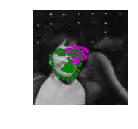

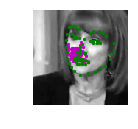

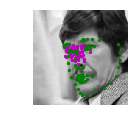

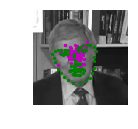

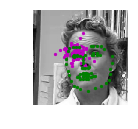

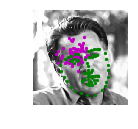

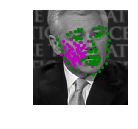

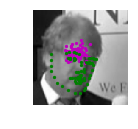

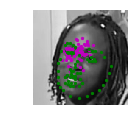

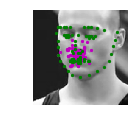

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        # transfer to cpu
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        # transfer to cpu
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss().cuda() if torch.cuda.is_available() else nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
#                 liveloss.update({
#                     'loss': running_loss/10
#                 })
#                 liveloss.draw()
#                 running_loss = 0.0

    print('Finished Training')


In [16]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

#liveloss = PlotLosses()

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.204490764439106
Epoch: 1, Batch: 20, Avg. Loss: 0.3216696910560131
Epoch: 1, Batch: 30, Avg. Loss: 0.4343658424913883
Epoch: 1, Batch: 40, Avg. Loss: 0.5329269129782915
Epoch: 1, Batch: 50, Avg. Loss: 0.6321874272078276
Epoch: 1, Batch: 60, Avg. Loss: 0.7492110397666693
Epoch: 1, Batch: 70, Avg. Loss: 0.8456867717206478
Epoch: 1, Batch: 80, Avg. Loss: 0.965207364782691
Epoch: 1, Batch: 90, Avg. Loss: 1.0762114975601436
Epoch: 1, Batch: 100, Avg. Loss: 1.1880421582609415
Epoch: 1, Batch: 110, Avg. Loss: 1.3223538082093
Epoch: 1, Batch: 120, Avg. Loss: 1.4288837119936943
Epoch: 1, Batch: 130, Avg. Loss: 1.5501703910529614
Epoch: 1, Batch: 140, Avg. Loss: 1.6428701534867287
Epoch: 1, Batch: 150, Avg. Loss: 1.7494368340820075
Epoch: 1, Batch: 160, Avg. Loss: 1.819798945263028
Epoch: 1, Batch: 170, Avg. Loss: 1.904862554743886
Epoch: 1, Batch: 180, Avg. Loss: 1.9775476690381766
Epoch: 1, Batch: 190, Avg. Loss: 2.0521974440664055
Epoch: 1, Batch: 200, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.06653019934892654
Epoch: 2, Batch: 20, Avg. Loss: 0.12958012148737907
Epoch: 2, Batch: 30, Avg. Loss: 0.18686687685549258
Epoch: 2, Batch: 40, Avg. Loss: 0.25201903358101846
Epoch: 2, Batch: 50, Avg. Loss: 0.30376811139285564
Epoch: 2, Batch: 60, Avg. Loss: 0.3697292497381568
Epoch: 2, Batch: 70, Avg. Loss: 0.42159714847803115
Epoch: 2, Batch: 80, Avg. Loss: 0.4692784292623401
Epoch: 2, Batch: 90, Avg. Loss: 0.5208304323256016
Epoch: 2, Batch: 100, Avg. Loss: 0.5736393865197897
Epoch: 2, Batch: 110, Avg. Loss: 0.6564557377249003
Epoch: 2, Batch: 120, Avg. Loss: 0.7145762115716934
Epoch: 2, Batch: 130, Avg. Loss: 0.7720264833420515
Epoch: 2, Batch: 140, Avg. Loss: 0.8372392199933529
Epoch: 2, Batch: 150, Avg. Loss: 0.8832845261320472
Epoch: 2, Batch: 160, Avg. Loss: 0.94298808388412
Epoch: 2, Batch: 170, Avg. Loss: 1.0139394875615835
Epoch: 2, Batch: 180, Avg. Loss: 1.0940541299059987
Epoch: 2, Batch: 190, Avg. Loss: 1.1474371308460831
Epoch: 2, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.04733483903110027
Epoch: 3, Batch: 20, Avg. Loss: 0.10050218719989061
Epoch: 3, Batch: 30, Avg. Loss: 0.16003476567566394
Epoch: 3, Batch: 40, Avg. Loss: 0.20447386763989925
Epoch: 3, Batch: 50, Avg. Loss: 0.24505620617419482
Epoch: 3, Batch: 60, Avg. Loss: 0.30213628690689803
Epoch: 3, Batch: 70, Avg. Loss: 0.4009345116093755
Epoch: 3, Batch: 80, Avg. Loss: 0.4572047840803862
Epoch: 3, Batch: 90, Avg. Loss: 0.516484454087913
Epoch: 3, Batch: 100, Avg. Loss: 0.5548028351739049
Epoch: 3, Batch: 110, Avg. Loss: 0.6063714101910591
Epoch: 3, Batch: 120, Avg. Loss: 0.6455414865165949
Epoch: 3, Batch: 130, Avg. Loss: 0.6918029362335801
Epoch: 3, Batch: 140, Avg. Loss: 0.7487917536869645
Epoch: 3, Batch: 150, Avg. Loss: 0.7869834179058671
Epoch: 3, Batch: 160, Avg. Loss: 0.8407546654343605
Epoch: 3, Batch: 170, Avg. Loss: 0.896663667447865
Epoch: 3, Batch: 180, Avg. Loss: 0.9520680118352175
Epoch: 3, Batch: 190, Avg. Loss: 0.9988856187090278
Epoch: 3, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.05541132017970085
Epoch: 4, Batch: 20, Avg. Loss: 0.09894488882273436
Epoch: 4, Batch: 30, Avg. Loss: 0.14763137344270943
Epoch: 4, Batch: 40, Avg. Loss: 0.2004332821816206
Epoch: 4, Batch: 50, Avg. Loss: 0.2419267812743783
Epoch: 4, Batch: 60, Avg. Loss: 0.28255446907132864
Epoch: 4, Batch: 70, Avg. Loss: 0.3364842081442475
Epoch: 4, Batch: 80, Avg. Loss: 0.36825023777782917
Epoch: 4, Batch: 90, Avg. Loss: 0.41405504401773213
Epoch: 4, Batch: 100, Avg. Loss: 0.46068589109927416
Epoch: 4, Batch: 110, Avg. Loss: 0.5053734362125397
Epoch: 4, Batch: 120, Avg. Loss: 0.5578743267804385
Epoch: 4, Batch: 130, Avg. Loss: 0.6007272589951753
Epoch: 4, Batch: 140, Avg. Loss: 0.6486777804791928
Epoch: 4, Batch: 150, Avg. Loss: 0.7017344448715448
Epoch: 4, Batch: 160, Avg. Loss: 0.7394332844763994
Epoch: 4, Batch: 170, Avg. Loss: 0.7667641006410122
Epoch: 4, Batch: 180, Avg. Loss: 0.8212478527799248
Epoch: 4, Batch: 190, Avg. Loss: 0.871251217275858
Epoch: 4, Batch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.05014631934463978
Epoch: 5, Batch: 20, Avg. Loss: 0.08933643689379096
Epoch: 5, Batch: 30, Avg. Loss: 0.13528094114735723
Epoch: 5, Batch: 40, Avg. Loss: 0.16871573412790894
Epoch: 5, Batch: 50, Avg. Loss: 0.1992467983625829
Epoch: 5, Batch: 60, Avg. Loss: 0.2651966753415763
Epoch: 5, Batch: 70, Avg. Loss: 0.31443655537441373
Epoch: 5, Batch: 80, Avg. Loss: 0.35169561859220266
Epoch: 5, Batch: 90, Avg. Loss: 0.3819515822455287
Epoch: 5, Batch: 100, Avg. Loss: 0.4424881929531693
Epoch: 5, Batch: 110, Avg. Loss: 0.4992702595889568
Epoch: 5, Batch: 120, Avg. Loss: 0.5384555123746395
Epoch: 5, Batch: 130, Avg. Loss: 0.5918764870613813
Epoch: 5, Batch: 140, Avg. Loss: 0.6395629029721022
Epoch: 5, Batch: 150, Avg. Loss: 0.6923888279125094
Epoch: 5, Batch: 160, Avg. Loss: 0.7501817306503653
Epoch: 5, Batch: 170, Avg. Loss: 0.7910315020009875
Epoch: 5, Batch: 180, Avg. Loss: 0.832199108041823
Epoch: 5, Batch: 190, Avg. Loss: 0.865555745176971
Epoch: 5, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.03320725373923779
Epoch: 6, Batch: 20, Avg. Loss: 0.08166194967925548
Epoch: 6, Batch: 30, Avg. Loss: 0.12639456782490016
Epoch: 6, Batch: 40, Avg. Loss: 0.1645511845126748
Epoch: 6, Batch: 50, Avg. Loss: 0.19642635229974986
Epoch: 6, Batch: 60, Avg. Loss: 0.23613164983689786
Epoch: 6, Batch: 70, Avg. Loss: 0.2967015843838453
Epoch: 6, Batch: 80, Avg. Loss: 0.32805162873119115
Epoch: 6, Batch: 90, Avg. Loss: 0.3662956114858389
Epoch: 6, Batch: 100, Avg. Loss: 0.41124563477933407
Epoch: 6, Batch: 110, Avg. Loss: 0.4487229371443391
Epoch: 6, Batch: 120, Avg. Loss: 0.48022342957556247
Epoch: 6, Batch: 130, Avg. Loss: 0.52101078806445
Epoch: 6, Batch: 140, Avg. Loss: 0.5528513834811747
Epoch: 6, Batch: 150, Avg. Loss: 0.5931647189892828
Epoch: 6, Batch: 160, Avg. Loss: 0.6266435288824141
Epoch: 6, Batch: 170, Avg. Loss: 0.6569666565395892
Epoch: 6, Batch: 180, Avg. Loss: 0.6892962488345802
Epoch: 6, Batch: 190, Avg. Loss: 0.7339865211397409
Epoch: 6, Batch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.030774722807109356
Epoch: 9, Batch: 20, Avg. Loss: 0.07766860798001289
Epoch: 9, Batch: 30, Avg. Loss: 0.10621115183457733
Epoch: 9, Batch: 40, Avg. Loss: 0.13693935619667172
Epoch: 9, Batch: 50, Avg. Loss: 0.173599661141634
Epoch: 9, Batch: 60, Avg. Loss: 0.20934337498620154
Epoch: 9, Batch: 70, Avg. Loss: 0.23913992140442134
Epoch: 9, Batch: 80, Avg. Loss: 0.27608640743419527
Epoch: 9, Batch: 90, Avg. Loss: 0.30157853523269296
Epoch: 9, Batch: 100, Avg. Loss: 0.35115109561011193
Epoch: 9, Batch: 110, Avg. Loss: 0.38374706292524935
Epoch: 9, Batch: 120, Avg. Loss: 0.4303647719323635
Epoch: 9, Batch: 130, Avg. Loss: 0.4661371437832713
Epoch: 9, Batch: 140, Avg. Loss: 0.4986791878938675
Epoch: 9, Batch: 150, Avg. Loss: 0.5417027566581964
Epoch: 9, Batch: 160, Avg. Loss: 0.5715707175433635
Epoch: 9, Batch: 170, Avg. Loss: 0.6006247889250517
Epoch: 9, Batch: 180, Avg. Loss: 0.6448826206848025
Epoch: 9, Batch: 190, Avg. Loss: 0.677562090754509
Epoch: 9, Ba

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.040373359061777594
Epoch: 10, Batch: 20, Avg. Loss: 0.08884721156209707
Epoch: 10, Batch: 30, Avg. Loss: 0.12425641305744647
Epoch: 10, Batch: 40, Avg. Loss: 0.15991045273840426
Epoch: 10, Batch: 50, Avg. Loss: 0.18934544045478105
Epoch: 10, Batch: 60, Avg. Loss: 0.22114412542432546
Epoch: 10, Batch: 70, Avg. Loss: 0.2444442080333829
Epoch: 10, Batch: 80, Avg. Loss: 0.27998530538752675
Epoch: 10, Batch: 90, Avg. Loss: 0.31423981552943586
Epoch: 10, Batch: 100, Avg. Loss: 0.3612059130333364
Epoch: 10, Batch: 110, Avg. Loss: 0.38790485840290784
Epoch: 10, Batch: 120, Avg. Loss: 0.425624274648726
Epoch: 10, Batch: 130, Avg. Loss: 0.46530286855995656
Epoch: 10, Batch: 140, Avg. Loss: 0.49600708689540624
Epoch: 10, Batch: 150, Avg. Loss: 0.5229609033092857
Epoch: 10, Batch: 160, Avg. Loss: 0.5559562649577856
Epoch: 10, Batch: 170, Avg. Loss: 0.5812451770529151
Epoch: 10, Batch: 180, Avg. Loss: 0.6199660425074398
Epoch: 10, Batch: 190, Avg. Loss: 0.65421345

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.056406961753964424
Epoch: 11, Batch: 20, Avg. Loss: 0.11032838821411133
Epoch: 11, Batch: 30, Avg. Loss: 0.16532636750489474
Epoch: 11, Batch: 40, Avg. Loss: 0.20585906971246004
Epoch: 11, Batch: 50, Avg. Loss: 0.23534777741879226
Epoch: 11, Batch: 60, Avg. Loss: 0.27081756964325904
Epoch: 11, Batch: 70, Avg. Loss: 0.3236841505393386
Epoch: 11, Batch: 80, Avg. Loss: 0.36387397479265926
Epoch: 11, Batch: 90, Avg. Loss: 0.415279053337872
Epoch: 11, Batch: 100, Avg. Loss: 0.44832560857757925
Epoch: 11, Batch: 110, Avg. Loss: 0.48542691888287665
Epoch: 11, Batch: 120, Avg. Loss: 0.523509631305933
Epoch: 11, Batch: 130, Avg. Loss: 0.5684798631817103
Epoch: 11, Batch: 140, Avg. Loss: 0.6167419612407684
Epoch: 11, Batch: 150, Avg. Loss: 0.6550217404030263
Epoch: 11, Batch: 160, Avg. Loss: 0.6929707499220967
Epoch: 11, Batch: 170, Avg. Loss: 0.7214387614279986
Epoch: 11, Batch: 180, Avg. Loss: 0.760702502541244
Epoch: 11, Batch: 190, Avg. Loss: 0.787857158016

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.028872733097523452
Epoch: 12, Batch: 20, Avg. Loss: 0.06227795835584402
Epoch: 12, Batch: 30, Avg. Loss: 0.12260675746947527
Epoch: 12, Batch: 40, Avg. Loss: 0.14674372393637897
Epoch: 12, Batch: 50, Avg. Loss: 0.17713820124045015
Epoch: 12, Batch: 60, Avg. Loss: 0.20814702631905674
Epoch: 12, Batch: 70, Avg. Loss: 0.23520731646567583
Epoch: 12, Batch: 80, Avg. Loss: 0.25947231194004416
Epoch: 12, Batch: 90, Avg. Loss: 0.289831686578691
Epoch: 12, Batch: 100, Avg. Loss: 0.3140262591652572
Epoch: 12, Batch: 110, Avg. Loss: 0.3640046504326165
Epoch: 12, Batch: 120, Avg. Loss: 0.3943407261744142
Epoch: 12, Batch: 130, Avg. Loss: 0.4289878845214844
Epoch: 12, Batch: 140, Avg. Loss: 0.45417974786832926
Epoch: 12, Batch: 150, Avg. Loss: 0.47938794987276195
Epoch: 12, Batch: 160, Avg. Loss: 0.5143747651018202
Epoch: 12, Batch: 170, Avg. Loss: 0.551872403267771
Epoch: 12, Batch: 180, Avg. Loss: 0.5778390861116349
Epoch: 12, Batch: 190, Avg. Loss: 0.6109418160

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.034057298116385935
Epoch: 13, Batch: 20, Avg. Loss: 0.07805004874244333
Epoch: 13, Batch: 30, Avg. Loss: 0.12311792997643352
Epoch: 13, Batch: 40, Avg. Loss: 0.16718058818951248
Epoch: 13, Batch: 50, Avg. Loss: 0.1996223504655063
Epoch: 13, Batch: 60, Avg. Loss: 0.23109065946191548
Epoch: 13, Batch: 70, Avg. Loss: 0.2611819127574563
Epoch: 13, Batch: 80, Avg. Loss: 0.29484341805800796
Epoch: 13, Batch: 90, Avg. Loss: 0.32957955757156016
Epoch: 13, Batch: 100, Avg. Loss: 0.35961214927956464
Epoch: 13, Batch: 110, Avg. Loss: 0.3824450016953051
Epoch: 13, Batch: 120, Avg. Loss: 0.40928321341052654
Epoch: 13, Batch: 130, Avg. Loss: 0.43946365658193826
Epoch: 13, Batch: 140, Avg. Loss: 0.47926703076809646
Epoch: 13, Batch: 150, Avg. Loss: 0.5120968477800488
Epoch: 13, Batch: 160, Avg. Loss: 0.5492852911353111
Epoch: 13, Batch: 170, Avg. Loss: 0.581432438082993
Epoch: 13, Batch: 180, Avg. Loss: 0.6098466143012047
Epoch: 13, Batch: 190, Avg. Loss: 0.64515556

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.0211775379255414
Epoch: 14, Batch: 20, Avg. Loss: 0.0459810939617455
Epoch: 14, Batch: 30, Avg. Loss: 0.08250242685899138
Epoch: 14, Batch: 40, Avg. Loss: 0.11258445819839835
Epoch: 14, Batch: 50, Avg. Loss: 0.133180002681911
Epoch: 14, Batch: 60, Avg. Loss: 0.1863537285476923
Epoch: 14, Batch: 70, Avg. Loss: 0.2186830543912947
Epoch: 14, Batch: 80, Avg. Loss: 0.2506418383680284
Epoch: 14, Batch: 90, Avg. Loss: 0.2774252099916339
Epoch: 14, Batch: 100, Avg. Loss: 0.3044692654162645
Epoch: 14, Batch: 110, Avg. Loss: 0.3310271162539721
Epoch: 14, Batch: 120, Avg. Loss: 0.3548279993236065
Epoch: 14, Batch: 130, Avg. Loss: 0.38190127732232215
Epoch: 14, Batch: 140, Avg. Loss: 0.40266796201467514
Epoch: 14, Batch: 150, Avg. Loss: 0.4285794391296804
Epoch: 14, Batch: 160, Avg. Loss: 0.45712358979508283
Epoch: 14, Batch: 170, Avg. Loss: 0.4786217131651938
Epoch: 14, Batch: 180, Avg. Loss: 0.5058015087619424
Epoch: 14, Batch: 190, Avg. Loss: 0.526517548505216

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.02792930705472827
Epoch: 15, Batch: 20, Avg. Loss: 0.04992583990097046
Epoch: 15, Batch: 30, Avg. Loss: 0.0786060206592083
Epoch: 15, Batch: 40, Avg. Loss: 0.10764606082811952
Epoch: 15, Batch: 50, Avg. Loss: 0.13317560767754913
Epoch: 15, Batch: 60, Avg. Loss: 0.1570337314158678
Epoch: 15, Batch: 70, Avg. Loss: 0.18132581282407045
Epoch: 15, Batch: 80, Avg. Loss: 0.20755227338522672
Epoch: 15, Batch: 90, Avg. Loss: 0.23973877672106028
Epoch: 15, Batch: 100, Avg. Loss: 0.28285538107156755
Epoch: 15, Batch: 110, Avg. Loss: 0.3144363730214536
Epoch: 15, Batch: 120, Avg. Loss: 0.33768082931637766
Epoch: 15, Batch: 130, Avg. Loss: 0.36635134778916834
Epoch: 15, Batch: 140, Avg. Loss: 0.4165733057074249
Epoch: 15, Batch: 150, Avg. Loss: 0.4461355646140873
Epoch: 15, Batch: 160, Avg. Loss: 0.4683000210672617
Epoch: 15, Batch: 170, Avg. Loss: 0.5013185873627662
Epoch: 15, Batch: 180, Avg. Loss: 0.5335300407372415
Epoch: 15, Batch: 190, Avg. Loss: 0.556857163

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.02862128894776106
Epoch: 16, Batch: 20, Avg. Loss: 0.05000781314447522
Epoch: 16, Batch: 30, Avg. Loss: 0.08773674350231886
Epoch: 16, Batch: 40, Avg. Loss: 0.11502212183550001
Epoch: 16, Batch: 50, Avg. Loss: 0.13692905586212872
Epoch: 16, Batch: 60, Avg. Loss: 0.15770073113963007
Epoch: 16, Batch: 70, Avg. Loss: 0.17682212833315133
Epoch: 16, Batch: 80, Avg. Loss: 0.19664428904652595
Epoch: 16, Batch: 90, Avg. Loss: 0.23202824387699367
Epoch: 16, Batch: 100, Avg. Loss: 0.2679972560144961
Epoch: 16, Batch: 110, Avg. Loss: 0.3029228084720671
Epoch: 16, Batch: 120, Avg. Loss: 0.34546569595113397
Epoch: 16, Batch: 130, Avg. Loss: 0.389515863545239
Epoch: 16, Batch: 140, Avg. Loss: 0.4211538637988269
Epoch: 16, Batch: 150, Avg. Loss: 0.44255187567323445
Epoch: 16, Batch: 160, Avg. Loss: 0.46827615099027753
Epoch: 16, Batch: 170, Avg. Loss: 0.5047119679860771
Epoch: 16, Batch: 180, Avg. Loss: 0.5348328039050102
Epoch: 16, Batch: 190, Avg. Loss: 0.56372610

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.024528637900948523
Epoch: 17, Batch: 20, Avg. Loss: 0.0555835148319602
Epoch: 17, Batch: 30, Avg. Loss: 0.08427678141742945
Epoch: 17, Batch: 40, Avg. Loss: 0.10908481683582068
Epoch: 17, Batch: 50, Avg. Loss: 0.13449061959981917
Epoch: 17, Batch: 60, Avg. Loss: 0.174407082144171
Epoch: 17, Batch: 70, Avg. Loss: 0.19945335956290364
Epoch: 17, Batch: 80, Avg. Loss: 0.2326041608117521
Epoch: 17, Batch: 90, Avg. Loss: 0.265863711386919
Epoch: 17, Batch: 100, Avg. Loss: 0.3088735810481012
Epoch: 17, Batch: 110, Avg. Loss: 0.3333931066095829
Epoch: 17, Batch: 120, Avg. Loss: 0.35698657352477314
Epoch: 17, Batch: 130, Avg. Loss: 0.3785199551843107
Epoch: 17, Batch: 140, Avg. Loss: 0.40238123750314114
Epoch: 17, Batch: 150, Avg. Loss: 0.4424298980273306
Epoch: 17, Batch: 160, Avg. Loss: 0.47550414288416504
Epoch: 17, Batch: 170, Avg. Loss: 0.5053070331923664
Epoch: 17, Batch: 180, Avg. Loss: 0.5279098258353769
Epoch: 17, Batch: 190, Avg. Loss: 0.553616461157

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.023285504430532455
Epoch: 18, Batch: 20, Avg. Loss: 0.04464224614202976
Epoch: 18, Batch: 30, Avg. Loss: 0.06952668633311987
Epoch: 18, Batch: 40, Avg. Loss: 0.09152979021891952
Epoch: 18, Batch: 50, Avg. Loss: 0.11501844972372055
Epoch: 18, Batch: 60, Avg. Loss: 0.13312422866001725
Epoch: 18, Batch: 70, Avg. Loss: 0.15566633278504013
Epoch: 18, Batch: 80, Avg. Loss: 0.17863945057615638
Epoch: 18, Batch: 90, Avg. Loss: 0.1969757462851703
Epoch: 18, Batch: 100, Avg. Loss: 0.23175496654585004
Epoch: 18, Batch: 110, Avg. Loss: 0.2587161460891366
Epoch: 18, Batch: 120, Avg. Loss: 0.2960471815429628
Epoch: 18, Batch: 130, Avg. Loss: 0.3246559267863631
Epoch: 18, Batch: 140, Avg. Loss: 0.3526631518267095
Epoch: 18, Batch: 150, Avg. Loss: 0.3831701108254492
Epoch: 18, Batch: 160, Avg. Loss: 0.4297707283869386
Epoch: 18, Batch: 170, Avg. Loss: 0.4552447791211307
Epoch: 18, Batch: 180, Avg. Loss: 0.4743594558909535
Epoch: 18, Batch: 190, Avg. Loss: 0.508547439

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.02290810951963067
Epoch: 19, Batch: 20, Avg. Loss: 0.04654041407629848
Epoch: 19, Batch: 30, Avg. Loss: 0.07162322178483009
Epoch: 19, Batch: 40, Avg. Loss: 0.09312660852447152
Epoch: 19, Batch: 50, Avg. Loss: 0.11472848765552043
Epoch: 19, Batch: 60, Avg. Loss: 0.1365917264483869
Epoch: 19, Batch: 70, Avg. Loss: 0.16305301049724222
Epoch: 19, Batch: 80, Avg. Loss: 0.1951380591839552
Epoch: 19, Batch: 90, Avg. Loss: 0.2227587725035846
Epoch: 19, Batch: 100, Avg. Loss: 0.25055532436817884
Epoch: 19, Batch: 110, Avg. Loss: 0.2791567524895072
Epoch: 19, Batch: 120, Avg. Loss: 0.31509251426905394
Epoch: 19, Batch: 130, Avg. Loss: 0.3513163677416742
Epoch: 19, Batch: 140, Avg. Loss: 0.37855413686484096
Epoch: 19, Batch: 150, Avg. Loss: 0.4031634175218642
Epoch: 19, Batch: 160, Avg. Loss: 0.41985723515972495
Epoch: 19, Batch: 170, Avg. Loss: 0.45807674126699566
Epoch: 19, Batch: 180, Avg. Loss: 0.49243364948779345
Epoch: 19, Batch: 190, Avg. Loss: 0.5147519

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.021918505243957043
Epoch: 20, Batch: 20, Avg. Loss: 0.04677708717063069
Epoch: 20, Batch: 30, Avg. Loss: 0.07135921642184258
Epoch: 20, Batch: 40, Avg. Loss: 0.09148453632369638
Epoch: 20, Batch: 50, Avg. Loss: 0.11854909136891364
Epoch: 20, Batch: 60, Avg. Loss: 0.14652536259964108
Epoch: 20, Batch: 70, Avg. Loss: 0.16573216300457716
Epoch: 20, Batch: 80, Avg. Loss: 0.1861223773099482
Epoch: 20, Batch: 90, Avg. Loss: 0.2165955732576549
Epoch: 20, Batch: 100, Avg. Loss: 0.2518936487846076
Epoch: 20, Batch: 110, Avg. Loss: 0.2754606463946402
Epoch: 20, Batch: 120, Avg. Loss: 0.29653647327795624
Epoch: 20, Batch: 130, Avg. Loss: 0.32125842915847896
Epoch: 20, Batch: 140, Avg. Loss: 0.3540180035866797
Epoch: 20, Batch: 150, Avg. Loss: 0.3735811426304281
Epoch: 20, Batch: 160, Avg. Loss: 0.4006010016426444
Epoch: 20, Batch: 170, Avg. Loss: 0.4214348826557398
Epoch: 20, Batch: 180, Avg. Loss: 0.4457558264955878
Epoch: 20, Batch: 190, Avg. Loss: 0.466463670

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.018713528849184514
Epoch: 21, Batch: 20, Avg. Loss: 0.038138416782021525
Epoch: 21, Batch: 30, Avg. Loss: 0.05868947943672538
Epoch: 21, Batch: 40, Avg. Loss: 0.08941143853589892
Epoch: 21, Batch: 50, Avg. Loss: 0.12082440396770835
Epoch: 21, Batch: 60, Avg. Loss: 0.14268734790384768
Epoch: 21, Batch: 70, Avg. Loss: 0.1621858729980886
Epoch: 21, Batch: 80, Avg. Loss: 0.21391687663272024
Epoch: 21, Batch: 90, Avg. Loss: 0.24087253203615547
Epoch: 21, Batch: 100, Avg. Loss: 0.2577496672980487
Epoch: 21, Batch: 110, Avg. Loss: 0.27733749989420176
Epoch: 21, Batch: 120, Avg. Loss: 0.29713816083967687
Epoch: 21, Batch: 130, Avg. Loss: 0.3237950040027499
Epoch: 21, Batch: 140, Avg. Loss: 0.35163673334755
Epoch: 21, Batch: 150, Avg. Loss: 0.3807608967181295
Epoch: 21, Batch: 160, Avg. Loss: 0.40350269847549497
Epoch: 21, Batch: 170, Avg. Loss: 0.4239576338324696
Epoch: 21, Batch: 180, Avg. Loss: 0.45061597651802004
Epoch: 21, Batch: 190, Avg. Loss: 0.4704643

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.04139655670151114
Epoch: 22, Batch: 20, Avg. Loss: 0.06013632016256452
Epoch: 22, Batch: 30, Avg. Loss: 0.11340890983119607
Epoch: 22, Batch: 40, Avg. Loss: 0.1311536262743175
Epoch: 22, Batch: 50, Avg. Loss: 0.16953000091016293
Epoch: 22, Batch: 60, Avg. Loss: 0.19242315096780657
Epoch: 22, Batch: 70, Avg. Loss: 0.22036548354662955
Epoch: 22, Batch: 80, Avg. Loss: 0.24553190493024885
Epoch: 22, Batch: 90, Avg. Loss: 0.26227287580259145
Epoch: 22, Batch: 100, Avg. Loss: 0.28649277552030983
Epoch: 22, Batch: 110, Avg. Loss: 0.31749026621691884
Epoch: 22, Batch: 120, Avg. Loss: 0.33632041937671603
Epoch: 22, Batch: 130, Avg. Loss: 0.36364221875555813
Epoch: 22, Batch: 140, Avg. Loss: 0.3881137485150248
Epoch: 22, Batch: 150, Avg. Loss: 0.4084570601116866
Epoch: 22, Batch: 160, Avg. Loss: 0.44066940383054315
Epoch: 22, Batch: 170, Avg. Loss: 0.4632775662932545
Epoch: 22, Batch: 180, Avg. Loss: 0.48227044749073683
Epoch: 22, Batch: 190, Avg. Loss: 0.50465

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.024452455807477236
Epoch: 23, Batch: 20, Avg. Loss: 0.04268146390095353
Epoch: 23, Batch: 30, Avg. Loss: 0.08234220677986741
Epoch: 23, Batch: 40, Avg. Loss: 0.10175664220005273
Epoch: 23, Batch: 50, Avg. Loss: 0.12023982368409633
Epoch: 23, Batch: 60, Avg. Loss: 0.14658438870683313
Epoch: 23, Batch: 70, Avg. Loss: 0.1688657791353762
Epoch: 23, Batch: 80, Avg. Loss: 0.18761629508808256
Epoch: 23, Batch: 90, Avg. Loss: 0.2082505188882351
Epoch: 23, Batch: 100, Avg. Loss: 0.23870962541550397
Epoch: 23, Batch: 110, Avg. Loss: 0.2635359472595155
Epoch: 23, Batch: 120, Avg. Loss: 0.28350460110232234
Epoch: 23, Batch: 130, Avg. Loss: 0.3086766739375889
Epoch: 23, Batch: 140, Avg. Loss: 0.3282737688161433
Epoch: 23, Batch: 150, Avg. Loss: 0.35343165807425975
Epoch: 23, Batch: 160, Avg. Loss: 0.376455070078373
Epoch: 23, Batch: 170, Avg. Loss: 0.39336218433454634
Epoch: 23, Batch: 180, Avg. Loss: 0.4224410525523126
Epoch: 23, Batch: 190, Avg. Loss: 0.44812885

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.021951006911695003
Epoch: 24, Batch: 20, Avg. Loss: 0.04405737379565835
Epoch: 24, Batch: 30, Avg. Loss: 0.06594446385279298
Epoch: 24, Batch: 40, Avg. Loss: 0.08562425393611192
Epoch: 24, Batch: 50, Avg. Loss: 0.10490451585501433
Epoch: 24, Batch: 60, Avg. Loss: 0.1398452788591385
Epoch: 24, Batch: 70, Avg. Loss: 0.1600050928071141
Epoch: 24, Batch: 80, Avg. Loss: 0.18304726583883166
Epoch: 24, Batch: 90, Avg. Loss: 0.2183969458565116
Epoch: 24, Batch: 100, Avg. Loss: 0.23533403798937796
Epoch: 24, Batch: 110, Avg. Loss: 0.2678587461821735
Epoch: 24, Batch: 120, Avg. Loss: 0.2880745974369347
Epoch: 24, Batch: 130, Avg. Loss: 0.3122351081110537
Epoch: 24, Batch: 140, Avg. Loss: 0.33822091314941644
Epoch: 24, Batch: 150, Avg. Loss: 0.35986139830201863
Epoch: 24, Batch: 160, Avg. Loss: 0.37846161145716906
Epoch: 24, Batch: 170, Avg. Loss: 0.39612236628308894
Epoch: 24, Batch: 180, Avg. Loss: 0.4225202356465161
Epoch: 24, Batch: 190, Avg. Loss: 0.4367404

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.03139880374073982
Epoch: 25, Batch: 20, Avg. Loss: 0.051880509778857234
Epoch: 25, Batch: 30, Avg. Loss: 0.08572703758254648
Epoch: 25, Batch: 40, Avg. Loss: 0.10510519351810217
Epoch: 25, Batch: 50, Avg. Loss: 0.12091725897043944
Epoch: 25, Batch: 60, Avg. Loss: 0.13588807182386517
Epoch: 25, Batch: 70, Avg. Loss: 0.16318493019789457
Epoch: 25, Batch: 80, Avg. Loss: 0.19520737556740642
Epoch: 25, Batch: 90, Avg. Loss: 0.22076478898525237
Epoch: 25, Batch: 100, Avg. Loss: 0.24183501163497567
Epoch: 25, Batch: 110, Avg. Loss: 0.26157507915049794
Epoch: 25, Batch: 120, Avg. Loss: 0.2891412578523159
Epoch: 25, Batch: 130, Avg. Loss: 0.3119977013207972
Epoch: 25, Batch: 140, Avg. Loss: 0.3319762215949595
Epoch: 25, Batch: 150, Avg. Loss: 0.3480808002874255
Epoch: 25, Batch: 160, Avg. Loss: 0.3702780721243471
Epoch: 25, Batch: 170, Avg. Loss: 0.39056831751950083
Epoch: 25, Batch: 180, Avg. Loss: 0.4087556947488338
Epoch: 25, Batch: 190, Avg. Loss: 0.424418

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.043790705222636464
Epoch: 26, Batch: 20, Avg. Loss: 0.06494092848151922
Epoch: 26, Batch: 30, Avg. Loss: 0.09475710755214095
Epoch: 26, Batch: 40, Avg. Loss: 0.11544225988909602
Epoch: 26, Batch: 50, Avg. Loss: 0.12981805270537733
Epoch: 26, Batch: 60, Avg. Loss: 0.15752883162349463
Epoch: 26, Batch: 70, Avg. Loss: 0.17540825121104717
Epoch: 26, Batch: 80, Avg. Loss: 0.2052703737281263
Epoch: 26, Batch: 90, Avg. Loss: 0.23161092652007936
Epoch: 26, Batch: 100, Avg. Loss: 0.24904345227405428
Epoch: 26, Batch: 110, Avg. Loss: 0.2685555060394108
Epoch: 26, Batch: 120, Avg. Loss: 0.28796841120347383
Epoch: 26, Batch: 130, Avg. Loss: 0.30325287813320756
Epoch: 26, Batch: 140, Avg. Loss: 0.32509811511263254
Epoch: 26, Batch: 150, Avg. Loss: 0.34619876807555555
Epoch: 26, Batch: 160, Avg. Loss: 0.3735545162111521
Epoch: 26, Batch: 170, Avg. Loss: 0.40171990511007605
Epoch: 26, Batch: 180, Avg. Loss: 0.42121371696703136
Epoch: 26, Batch: 190, Avg. Loss: 0.446

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.024515565484762192
Epoch: 27, Batch: 20, Avg. Loss: 0.04470340022817254
Epoch: 27, Batch: 30, Avg. Loss: 0.07197367306798697
Epoch: 27, Batch: 40, Avg. Loss: 0.09067808780819178
Epoch: 27, Batch: 50, Avg. Loss: 0.10713290423154831
Epoch: 27, Batch: 60, Avg. Loss: 0.12753674909472465
Epoch: 27, Batch: 70, Avg. Loss: 0.1410895728506148
Epoch: 27, Batch: 80, Avg. Loss: 0.16016449965536594
Epoch: 27, Batch: 90, Avg. Loss: 0.18882385054603218
Epoch: 27, Batch: 100, Avg. Loss: 0.2038081237114966
Epoch: 27, Batch: 110, Avg. Loss: 0.22160847801715136
Epoch: 27, Batch: 120, Avg. Loss: 0.2607687970623374
Epoch: 27, Batch: 130, Avg. Loss: 0.28704490680247546
Epoch: 27, Batch: 140, Avg. Loss: 0.308773772791028
Epoch: 27, Batch: 150, Avg. Loss: 0.32840913999825716
Epoch: 27, Batch: 160, Avg. Loss: 0.34822835261002183
Epoch: 27, Batch: 170, Avg. Loss: 0.36207555131986735
Epoch: 27, Batch: 180, Avg. Loss: 0.38150366870686414
Epoch: 27, Batch: 190, Avg. Loss: 0.39844

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.02033559326082468
Epoch: 28, Batch: 20, Avg. Loss: 0.03950678026303649
Epoch: 28, Batch: 30, Avg. Loss: 0.05840216176584363
Epoch: 28, Batch: 40, Avg. Loss: 0.0739954556338489
Epoch: 28, Batch: 50, Avg. Loss: 0.10392656186595559
Epoch: 28, Batch: 60, Avg. Loss: 0.11859245207160711
Epoch: 28, Batch: 70, Avg. Loss: 0.14072814639657735
Epoch: 28, Batch: 80, Avg. Loss: 0.16401218734681605
Epoch: 28, Batch: 90, Avg. Loss: 0.1799195704050362
Epoch: 28, Batch: 100, Avg. Loss: 0.19716160129755736
Epoch: 28, Batch: 110, Avg. Loss: 0.21944274064153432
Epoch: 28, Batch: 120, Avg. Loss: 0.2472762112505734
Epoch: 28, Batch: 130, Avg. Loss: 0.2657468791119754
Epoch: 28, Batch: 140, Avg. Loss: 0.2839833598583937
Epoch: 28, Batch: 150, Avg. Loss: 0.3061596407555044
Epoch: 28, Batch: 160, Avg. Loss: 0.3239315732382238
Epoch: 28, Batch: 170, Avg. Loss: 0.34083107477054
Epoch: 28, Batch: 180, Avg. Loss: 0.36261023934930564
Epoch: 28, Batch: 190, Avg. Loss: 0.38349804095

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.030108594801276922
Epoch: 29, Batch: 20, Avg. Loss: 0.07669251626357436
Epoch: 29, Batch: 30, Avg. Loss: 0.11476329574361444
Epoch: 29, Batch: 40, Avg. Loss: 0.14564330419525504
Epoch: 29, Batch: 50, Avg. Loss: 0.18839729512110354
Epoch: 29, Batch: 60, Avg. Loss: 0.21621941719204188
Epoch: 29, Batch: 70, Avg. Loss: 0.2572208009660244
Epoch: 29, Batch: 80, Avg. Loss: 0.28047236567363143
Epoch: 29, Batch: 90, Avg. Loss: 0.30462329657748344
Epoch: 29, Batch: 100, Avg. Loss: 0.3408270863816142
Epoch: 29, Batch: 110, Avg. Loss: 0.36835862081497905
Epoch: 29, Batch: 120, Avg. Loss: 0.41837766850367186
Epoch: 29, Batch: 130, Avg. Loss: 0.44605708960443735
Epoch: 29, Batch: 140, Avg. Loss: 0.4713122331537306
Epoch: 29, Batch: 150, Avg. Loss: 0.4952828256413341
Epoch: 29, Batch: 160, Avg. Loss: 0.5237433193251491
Epoch: 29, Batch: 170, Avg. Loss: 0.5491217476315796
Epoch: 29, Batch: 180, Avg. Loss: 0.5815672491677105
Epoch: 29, Batch: 190, Avg. Loss: 0.6018167

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.016220271959900855
Epoch: 30, Batch: 20, Avg. Loss: 0.03579636141657829
Epoch: 30, Batch: 30, Avg. Loss: 0.05676933145150542
Epoch: 30, Batch: 40, Avg. Loss: 0.0706033286638558
Epoch: 30, Batch: 50, Avg. Loss: 0.08768630130216479
Epoch: 30, Batch: 60, Avg. Loss: 0.10570784443989396
Epoch: 30, Batch: 70, Avg. Loss: 0.1225548424758017
Epoch: 30, Batch: 80, Avg. Loss: 0.16806444590911268
Epoch: 30, Batch: 90, Avg. Loss: 0.20071388063952328
Epoch: 30, Batch: 100, Avg. Loss: 0.21648410721682013
Epoch: 30, Batch: 110, Avg. Loss: 0.2357766832690686
Epoch: 30, Batch: 120, Avg. Loss: 0.2520796304102987
Epoch: 30, Batch: 130, Avg. Loss: 0.2751713230740279
Epoch: 30, Batch: 140, Avg. Loss: 0.2951280339155346
Epoch: 30, Batch: 150, Avg. Loss: 0.3115824273321778
Epoch: 30, Batch: 160, Avg. Loss: 0.33490137006156145
Epoch: 30, Batch: 170, Avg. Loss: 0.35361775462515654
Epoch: 30, Batch: 180, Avg. Loss: 0.37039505238644777
Epoch: 30, Batch: 190, Avg. Loss: 0.3858239

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.021699220640584826
Epoch: 31, Batch: 20, Avg. Loss: 0.03798672123812139
Epoch: 31, Batch: 30, Avg. Loss: 0.06140781291760504
Epoch: 31, Batch: 40, Avg. Loss: 0.07718700808472931
Epoch: 31, Batch: 50, Avg. Loss: 0.09666458400897682
Epoch: 31, Batch: 60, Avg. Loss: 0.11950404760427773
Epoch: 31, Batch: 70, Avg. Loss: 0.15177319957874716
Epoch: 31, Batch: 80, Avg. Loss: 0.17175637898035348
Epoch: 31, Batch: 90, Avg. Loss: 0.19486781335435807
Epoch: 31, Batch: 100, Avg. Loss: 0.21368071488104762
Epoch: 31, Batch: 110, Avg. Loss: 0.25020189727656544
Epoch: 31, Batch: 120, Avg. Loss: 0.2689530468080193
Epoch: 31, Batch: 130, Avg. Loss: 0.28871348234824834
Epoch: 31, Batch: 140, Avg. Loss: 0.3055723725352436
Epoch: 31, Batch: 150, Avg. Loss: 0.34257113584317267
Epoch: 31, Batch: 160, Avg. Loss: 0.36335238595493136
Epoch: 31, Batch: 170, Avg. Loss: 0.3812356257345527
Epoch: 31, Batch: 180, Avg. Loss: 0.3946355820633471
Epoch: 31, Batch: 190, Avg. Loss: 0.4213

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.030813988018780946
Epoch: 32, Batch: 20, Avg. Loss: 0.04742685528472066
Epoch: 32, Batch: 30, Avg. Loss: 0.07000768128782511
Epoch: 32, Batch: 40, Avg. Loss: 0.08710808223113417
Epoch: 32, Batch: 50, Avg. Loss: 0.10989149743691087
Epoch: 32, Batch: 60, Avg. Loss: 0.12525038439780473
Epoch: 32, Batch: 70, Avg. Loss: 0.1460222070105374
Epoch: 32, Batch: 80, Avg. Loss: 0.1804281694814563
Epoch: 32, Batch: 90, Avg. Loss: 0.20116137051954866
Epoch: 32, Batch: 100, Avg. Loss: 0.23549767378717662
Epoch: 32, Batch: 110, Avg. Loss: 0.2546549347229302
Epoch: 32, Batch: 120, Avg. Loss: 0.27247161185368896
Epoch: 32, Batch: 130, Avg. Loss: 0.2899481332860887
Epoch: 32, Batch: 140, Avg. Loss: 0.30669370517134664
Epoch: 32, Batch: 150, Avg. Loss: 0.3209219090640545
Epoch: 32, Batch: 160, Avg. Loss: 0.33820760026574137
Epoch: 32, Batch: 170, Avg. Loss: 0.3563668098300695
Epoch: 32, Batch: 180, Avg. Loss: 0.3749484859406948
Epoch: 32, Batch: 190, Avg. Loss: 0.3904595

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.014812507387250661
Epoch: 33, Batch: 20, Avg. Loss: 0.034224547492340204
Epoch: 33, Batch: 30, Avg. Loss: 0.0518257166724652
Epoch: 33, Batch: 40, Avg. Loss: 0.06979160574264824
Epoch: 33, Batch: 50, Avg. Loss: 0.099321771832183
Epoch: 33, Batch: 60, Avg. Loss: 0.1150410225149244
Epoch: 33, Batch: 70, Avg. Loss: 0.13111651581712067
Epoch: 33, Batch: 80, Avg. Loss: 0.14657774991355838
Epoch: 33, Batch: 90, Avg. Loss: 0.16474526268430054
Epoch: 33, Batch: 100, Avg. Loss: 0.18364966087974607
Epoch: 33, Batch: 110, Avg. Loss: 0.20256518977694213
Epoch: 33, Batch: 120, Avg. Loss: 0.22358036432415246
Epoch: 33, Batch: 130, Avg. Loss: 0.24008959461934865
Epoch: 33, Batch: 140, Avg. Loss: 0.25715963742695747
Epoch: 33, Batch: 150, Avg. Loss: 0.2797748344484717
Epoch: 33, Batch: 160, Avg. Loss: 0.29423698685131966
Epoch: 33, Batch: 170, Avg. Loss: 0.3134216197300702
Epoch: 33, Batch: 180, Avg. Loss: 0.35451562092639505
Epoch: 33, Batch: 190, Avg. Loss: 0.37618

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.023238032311201095
Epoch: 34, Batch: 20, Avg. Loss: 0.043237338028848174
Epoch: 34, Batch: 30, Avg. Loss: 0.07382065802812576
Epoch: 34, Batch: 40, Avg. Loss: 0.08702150913886726
Epoch: 34, Batch: 50, Avg. Loss: 0.10572886024601758
Epoch: 34, Batch: 60, Avg. Loss: 0.11896372754126787
Epoch: 34, Batch: 70, Avg. Loss: 0.13795814057812095
Epoch: 34, Batch: 80, Avg. Loss: 0.15937389377504588
Epoch: 34, Batch: 90, Avg. Loss: 0.17438649507239462
Epoch: 34, Batch: 100, Avg. Loss: 0.1869858281686902
Epoch: 34, Batch: 110, Avg. Loss: 0.20560986157506705
Epoch: 34, Batch: 120, Avg. Loss: 0.22001253897324205
Epoch: 34, Batch: 130, Avg. Loss: 0.23837252967059613
Epoch: 34, Batch: 140, Avg. Loss: 0.2581032673828304
Epoch: 34, Batch: 150, Avg. Loss: 0.27375211054459214
Epoch: 34, Batch: 160, Avg. Loss: 0.28624846395105125
Epoch: 34, Batch: 170, Avg. Loss: 0.30402064928784966
Epoch: 34, Batch: 180, Avg. Loss: 0.31998361395671965
Epoch: 34, Batch: 190, Avg. Loss: 0.3

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.021014839969575407
Epoch: 35, Batch: 20, Avg. Loss: 0.03745708903297782
Epoch: 35, Batch: 30, Avg. Loss: 0.05565586751326919
Epoch: 35, Batch: 40, Avg. Loss: 0.071358672529459
Epoch: 35, Batch: 50, Avg. Loss: 0.08506698049604892
Epoch: 35, Batch: 60, Avg. Loss: 0.10815529036335647
Epoch: 35, Batch: 70, Avg. Loss: 0.1258820909075439
Epoch: 35, Batch: 80, Avg. Loss: 0.1405799993313849
Epoch: 35, Batch: 90, Avg. Loss: 0.15598027547821403
Epoch: 35, Batch: 100, Avg. Loss: 0.17064406904391943
Epoch: 35, Batch: 110, Avg. Loss: 0.18705939226783813
Epoch: 35, Batch: 120, Avg. Loss: 0.20840717614628373
Epoch: 35, Batch: 130, Avg. Loss: 0.2222589048091322
Epoch: 35, Batch: 140, Avg. Loss: 0.2372169080656022
Epoch: 35, Batch: 150, Avg. Loss: 0.2563957002479583
Epoch: 35, Batch: 160, Avg. Loss: 0.2727401176001877
Epoch: 35, Batch: 170, Avg. Loss: 0.2906696686986834
Epoch: 35, Batch: 180, Avg. Loss: 0.3080394795630127
Epoch: 35, Batch: 190, Avg. Loss: 0.3256360469

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.019714847952127457
Epoch: 36, Batch: 20, Avg. Loss: 0.03668786669149995
Epoch: 36, Batch: 30, Avg. Loss: 0.05924837468191981
Epoch: 36, Batch: 40, Avg. Loss: 0.08708857651799917
Epoch: 36, Batch: 50, Avg. Loss: 0.10604554750025272
Epoch: 36, Batch: 60, Avg. Loss: 0.12249707179144025
Epoch: 36, Batch: 70, Avg. Loss: 0.13933900743722916
Epoch: 36, Batch: 80, Avg. Loss: 0.15917290840297937
Epoch: 36, Batch: 90, Avg. Loss: 0.1816582128405571
Epoch: 36, Batch: 100, Avg. Loss: 0.19930870952084662
Epoch: 36, Batch: 110, Avg. Loss: 0.21968081947416068
Epoch: 36, Batch: 120, Avg. Loss: 0.23985980665311218
Epoch: 36, Batch: 130, Avg. Loss: 0.2586433063261211
Epoch: 36, Batch: 140, Avg. Loss: 0.27748486381024123
Epoch: 36, Batch: 150, Avg. Loss: 0.29034120454452933
Epoch: 36, Batch: 160, Avg. Loss: 0.3114267798606306
Epoch: 36, Batch: 170, Avg. Loss: 0.32951836665160955
Epoch: 36, Batch: 180, Avg. Loss: 0.350122842611745
Epoch: 36, Batch: 190, Avg. Loss: 0.36877

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.02237953254953027
Epoch: 37, Batch: 20, Avg. Loss: 0.03973035244271159
Epoch: 37, Batch: 30, Avg. Loss: 0.05657266341149807
Epoch: 37, Batch: 40, Avg. Loss: 0.07135213036090135
Epoch: 37, Batch: 50, Avg. Loss: 0.08469561599195004
Epoch: 37, Batch: 60, Avg. Loss: 0.1057755802758038
Epoch: 37, Batch: 70, Avg. Loss: 0.12216030294075608
Epoch: 37, Batch: 80, Avg. Loss: 0.13731957664713262
Epoch: 37, Batch: 90, Avg. Loss: 0.15448622638359666
Epoch: 37, Batch: 100, Avg. Loss: 0.1683662448078394
Epoch: 37, Batch: 110, Avg. Loss: 0.1857058689929545
Epoch: 37, Batch: 120, Avg. Loss: 0.19998876927420497
Epoch: 37, Batch: 130, Avg. Loss: 0.21627664947882294
Epoch: 37, Batch: 140, Avg. Loss: 0.23601842680945992
Epoch: 37, Batch: 150, Avg. Loss: 0.25302690719254317
Epoch: 37, Batch: 160, Avg. Loss: 0.2827543301042169
Epoch: 37, Batch: 170, Avg. Loss: 0.3019017339684069
Epoch: 37, Batch: 180, Avg. Loss: 0.31537310369312765
Epoch: 37, Batch: 190, Avg. Loss: 0.328379

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.01618856322020292
Epoch: 38, Batch: 20, Avg. Loss: 0.0344657470472157
Epoch: 38, Batch: 30, Avg. Loss: 0.052619063574820754
Epoch: 38, Batch: 40, Avg. Loss: 0.07022810047492385
Epoch: 38, Batch: 50, Avg. Loss: 0.08804606553167105
Epoch: 38, Batch: 60, Avg. Loss: 0.10032313968986273
Epoch: 38, Batch: 70, Avg. Loss: 0.11632831022143364
Epoch: 38, Batch: 80, Avg. Loss: 0.13114431416615843
Epoch: 38, Batch: 90, Avg. Loss: 0.14443196011707188
Epoch: 38, Batch: 100, Avg. Loss: 0.179832865903154
Epoch: 38, Batch: 110, Avg. Loss: 0.19422314558178186
Epoch: 38, Batch: 120, Avg. Loss: 0.211517586838454
Epoch: 38, Batch: 130, Avg. Loss: 0.23683226853609085
Epoch: 38, Batch: 140, Avg. Loss: 0.25500472942367197
Epoch: 38, Batch: 150, Avg. Loss: 0.26930446992628276
Epoch: 38, Batch: 160, Avg. Loss: 0.2858061534818262
Epoch: 38, Batch: 170, Avg. Loss: 0.3202408246230334
Epoch: 38, Batch: 180, Avg. Loss: 0.3358297826256603
Epoch: 38, Batch: 190, Avg. Loss: 0.35284118

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.013756327237933874
Epoch: 39, Batch: 20, Avg. Loss: 0.02673840634524822
Epoch: 39, Batch: 30, Avg. Loss: 0.040503685269504784
Epoch: 39, Batch: 40, Avg. Loss: 0.05409506456926465
Epoch: 39, Batch: 50, Avg. Loss: 0.06972517226822675
Epoch: 39, Batch: 60, Avg. Loss: 0.08498539738357067
Epoch: 39, Batch: 70, Avg. Loss: 0.10104327658191323
Epoch: 39, Batch: 80, Avg. Loss: 0.11705348701216281
Epoch: 39, Batch: 90, Avg. Loss: 0.1317166059743613
Epoch: 39, Batch: 100, Avg. Loss: 0.1481556779704988
Epoch: 39, Batch: 110, Avg. Loss: 0.17251517288386822
Epoch: 39, Batch: 120, Avg. Loss: 0.1838766023516655
Epoch: 39, Batch: 130, Avg. Loss: 0.2003341032192111
Epoch: 39, Batch: 140, Avg. Loss: 0.2489431280642748
Epoch: 39, Batch: 150, Avg. Loss: 0.2798508542589843
Epoch: 39, Batch: 160, Avg. Loss: 0.2969280485995114
Epoch: 39, Batch: 170, Avg. Loss: 0.3228131577372551
Epoch: 39, Batch: 180, Avg. Loss: 0.33792014215141536
Epoch: 39, Batch: 190, Avg. Loss: 0.3592458

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.019436901807785033
Epoch: 40, Batch: 20, Avg. Loss: 0.049173977319151164
Epoch: 40, Batch: 30, Avg. Loss: 0.08653693865053355
Epoch: 40, Batch: 40, Avg. Loss: 0.1039671917911619
Epoch: 40, Batch: 50, Avg. Loss: 0.11673569902777672
Epoch: 40, Batch: 60, Avg. Loss: 0.1383243705611676
Epoch: 40, Batch: 70, Avg. Loss: 0.1529763629194349
Epoch: 40, Batch: 80, Avg. Loss: 0.1763441692572087
Epoch: 40, Batch: 90, Avg. Loss: 0.19166480214335024
Epoch: 40, Batch: 100, Avg. Loss: 0.20544137149117886
Epoch: 40, Batch: 110, Avg. Loss: 0.23676209910772741
Epoch: 40, Batch: 120, Avg. Loss: 0.2680426510516554
Epoch: 40, Batch: 130, Avg. Loss: 0.2835338919889182
Epoch: 40, Batch: 140, Avg. Loss: 0.3009020274039358
Epoch: 40, Batch: 150, Avg. Loss: 0.31864841501228514
Epoch: 40, Batch: 160, Avg. Loss: 0.3347651537973434
Epoch: 40, Batch: 170, Avg. Loss: 0.3520966290961951
Epoch: 40, Batch: 180, Avg. Loss: 0.368582919659093
Epoch: 40, Batch: 190, Avg. Loss: 0.3806733967

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 41, Batch: 10, Avg. Loss: 0.021851477958261967
Epoch: 41, Batch: 20, Avg. Loss: 0.06566116865724325
Epoch: 41, Batch: 30, Avg. Loss: 0.09019723879173398
Epoch: 41, Batch: 40, Avg. Loss: 0.12688508220016956
Epoch: 41, Batch: 50, Avg. Loss: 0.15316326823085546
Epoch: 41, Batch: 60, Avg. Loss: 0.17583774253726006
Epoch: 41, Batch: 70, Avg. Loss: 0.2097858203575015
Epoch: 41, Batch: 80, Avg. Loss: 0.2352137858979404
Epoch: 41, Batch: 90, Avg. Loss: 0.263868619967252
Epoch: 41, Batch: 100, Avg. Loss: 0.2820178664289415
Epoch: 41, Batch: 110, Avg. Loss: 0.3043174175545573
Epoch: 41, Batch: 120, Avg. Loss: 0.32424122365191577
Epoch: 41, Batch: 130, Avg. Loss: 0.34244744749739764
Epoch: 41, Batch: 140, Avg. Loss: 0.3753847494721413
Epoch: 41, Batch: 150, Avg. Loss: 0.3976127547211945
Epoch: 41, Batch: 160, Avg. Loss: 0.4440558783710003
Epoch: 41, Batch: 170, Avg. Loss: 0.4745163511484861
Epoch: 41, Batch: 180, Avg. Loss: 0.4930583972018212
Epoch: 41, Batch: 190, Avg. Loss: 0.52655458659

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 42, Batch: 10, Avg. Loss: 0.01924754735082388
Epoch: 42, Batch: 20, Avg. Loss: 0.04271464282646775
Epoch: 42, Batch: 30, Avg. Loss: 0.07113258251920343
Epoch: 42, Batch: 40, Avg. Loss: 0.08835828080773353
Epoch: 42, Batch: 50, Avg. Loss: 0.11359429955482483
Epoch: 42, Batch: 60, Avg. Loss: 0.1430805060081184
Epoch: 42, Batch: 70, Avg. Loss: 0.16049722339957953
Epoch: 42, Batch: 80, Avg. Loss: 0.1769280256703496
Epoch: 42, Batch: 90, Avg. Loss: 0.1984392092563212
Epoch: 42, Batch: 100, Avg. Loss: 0.21511003328487277
Epoch: 42, Batch: 110, Avg. Loss: 0.2325963431969285
Epoch: 42, Batch: 120, Avg. Loss: 0.24558810144662857
Epoch: 42, Batch: 130, Avg. Loss: 0.2626585638616234
Epoch: 42, Batch: 140, Avg. Loss: 0.2800393213983625
Epoch: 42, Batch: 150, Avg. Loss: 0.2937872316222638
Epoch: 42, Batch: 160, Avg. Loss: 0.314461751608178
Epoch: 42, Batch: 170, Avg. Loss: 0.33808657992631197
Epoch: 42, Batch: 180, Avg. Loss: 0.35415892144665123
Epoch: 42, Batch: 190, Avg. Loss: 0.3714106881

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 43, Batch: 10, Avg. Loss: 0.016882714256644248
Epoch: 43, Batch: 20, Avg. Loss: 0.035832257475703955
Epoch: 43, Batch: 30, Avg. Loss: 0.05892686084844172
Epoch: 43, Batch: 40, Avg. Loss: 0.07772203274071217
Epoch: 43, Batch: 50, Avg. Loss: 0.09716340871527791
Epoch: 43, Batch: 60, Avg. Loss: 0.12074135392904281
Epoch: 43, Batch: 70, Avg. Loss: 0.1410468972288072
Epoch: 43, Batch: 80, Avg. Loss: 0.16037242417223752
Epoch: 43, Batch: 90, Avg. Loss: 0.1818009355571121
Epoch: 43, Batch: 100, Avg. Loss: 0.2008281811606139
Epoch: 43, Batch: 110, Avg. Loss: 0.23149960711598397
Epoch: 43, Batch: 120, Avg. Loss: 0.2868616466410458
Epoch: 43, Batch: 130, Avg. Loss: 0.30113330082967876
Epoch: 43, Batch: 140, Avg. Loss: 0.31589971552602947
Epoch: 43, Batch: 150, Avg. Loss: 0.3344590166117996
Epoch: 43, Batch: 160, Avg. Loss: 0.35549311828799546
Epoch: 43, Batch: 170, Avg. Loss: 0.3749475014861673
Epoch: 43, Batch: 180, Avg. Loss: 0.39546148241497575
Epoch: 43, Batch: 190, Avg. Loss: 0.41169

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 44, Batch: 10, Avg. Loss: 0.014950316213071347
Epoch: 44, Batch: 20, Avg. Loss: 0.02877160981297493
Epoch: 44, Batch: 30, Avg. Loss: 0.0504947111941874
Epoch: 44, Batch: 40, Avg. Loss: 0.06673210132867098
Epoch: 44, Batch: 50, Avg. Loss: 0.09334088666364551
Epoch: 44, Batch: 60, Avg. Loss: 0.10758086671121418
Epoch: 44, Batch: 70, Avg. Loss: 0.12201308771036565
Epoch: 44, Batch: 80, Avg. Loss: 0.13489396437071263
Epoch: 44, Batch: 90, Avg. Loss: 0.15509422207251192
Epoch: 44, Batch: 100, Avg. Loss: 0.17475376110523938
Epoch: 44, Batch: 110, Avg. Loss: 0.18879607720300556
Epoch: 44, Batch: 120, Avg. Loss: 0.20534130269661546
Epoch: 44, Batch: 130, Avg. Loss: 0.2317580660805106
Epoch: 44, Batch: 140, Avg. Loss: 0.24936701823025942
Epoch: 44, Batch: 150, Avg. Loss: 0.26395920803770423
Epoch: 44, Batch: 160, Avg. Loss: 0.2835663231089711
Epoch: 44, Batch: 170, Avg. Loss: 0.2999589228071272
Epoch: 44, Batch: 180, Avg. Loss: 0.3182735010050237
Epoch: 44, Batch: 190, Avg. Loss: 0.33570

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 45, Batch: 10, Avg. Loss: 0.023617788683623075
Epoch: 45, Batch: 20, Avg. Loss: 0.04047651812434196
Epoch: 45, Batch: 30, Avg. Loss: 0.057758538704365495
Epoch: 45, Batch: 40, Avg. Loss: 0.07488387757912278
Epoch: 45, Batch: 50, Avg. Loss: 0.08754711076617241
Epoch: 45, Batch: 60, Avg. Loss: 0.10251612598076462
Epoch: 45, Batch: 70, Avg. Loss: 0.12135120583698153
Epoch: 45, Batch: 80, Avg. Loss: 0.13897095238789917
Epoch: 45, Batch: 90, Avg. Loss: 0.15367966070771216
Epoch: 45, Batch: 100, Avg. Loss: 0.18567217919044196
Epoch: 45, Batch: 110, Avg. Loss: 0.19913708684034645
Epoch: 45, Batch: 120, Avg. Loss: 0.21340715480037034
Epoch: 45, Batch: 130, Avg. Loss: 0.22612499175593256
Epoch: 45, Batch: 140, Avg. Loss: 0.24344275668263435
Epoch: 45, Batch: 150, Avg. Loss: 0.2559785034507513
Epoch: 45, Batch: 160, Avg. Loss: 0.2726402443833649
Epoch: 45, Batch: 170, Avg. Loss: 0.28572492972016333
Epoch: 45, Batch: 180, Avg. Loss: 0.30179698010906575
Epoch: 45, Batch: 190, Avg. Loss: 0.3

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 46, Batch: 10, Avg. Loss: 0.01749888462945819
Epoch: 46, Batch: 20, Avg. Loss: 0.029865000769495963
Epoch: 46, Batch: 30, Avg. Loss: 0.046242066845297816
Epoch: 46, Batch: 40, Avg. Loss: 0.0590161083266139
Epoch: 46, Batch: 50, Avg. Loss: 0.07254568478092552
Epoch: 46, Batch: 60, Avg. Loss: 0.0978870312217623
Epoch: 46, Batch: 70, Avg. Loss: 0.11309262593276799
Epoch: 46, Batch: 80, Avg. Loss: 0.12906045992858708
Epoch: 46, Batch: 90, Avg. Loss: 0.161591258039698
Epoch: 46, Batch: 100, Avg. Loss: 0.1773799942340702
Epoch: 46, Batch: 110, Avg. Loss: 0.1912618087604642
Epoch: 46, Batch: 120, Avg. Loss: 0.20881959944963455
Epoch: 46, Batch: 130, Avg. Loss: 0.22357890112325549
Epoch: 46, Batch: 140, Avg. Loss: 0.2369742256589234
Epoch: 46, Batch: 150, Avg. Loss: 0.2538362914696336
Epoch: 46, Batch: 160, Avg. Loss: 0.2709039402194321
Epoch: 46, Batch: 170, Avg. Loss: 0.3015427110716701
Epoch: 46, Batch: 180, Avg. Loss: 0.3176337688229978
Epoch: 46, Batch: 190, Avg. Loss: 0.3443573500

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 47, Batch: 10, Avg. Loss: 0.020721711032092572
Epoch: 47, Batch: 20, Avg. Loss: 0.052091939467936756
Epoch: 47, Batch: 30, Avg. Loss: 0.07595918430015444
Epoch: 47, Batch: 40, Avg. Loss: 0.09418559800833463
Epoch: 47, Batch: 50, Avg. Loss: 0.10722645791247487
Epoch: 47, Batch: 60, Avg. Loss: 0.12292637564241886
Epoch: 47, Batch: 70, Avg. Loss: 0.13837343258783222
Epoch: 47, Batch: 80, Avg. Loss: 0.15567920757457615
Epoch: 47, Batch: 90, Avg. Loss: 0.16778145325370133
Epoch: 47, Batch: 100, Avg. Loss: 0.181753141945228
Epoch: 47, Batch: 110, Avg. Loss: 0.19641573219560088
Epoch: 47, Batch: 120, Avg. Loss: 0.2087335739750415
Epoch: 47, Batch: 130, Avg. Loss: 0.22654237071983516
Epoch: 47, Batch: 140, Avg. Loss: 0.2534238678403199
Epoch: 47, Batch: 150, Avg. Loss: 0.2670871149748564
Epoch: 47, Batch: 160, Avg. Loss: 0.28385317446663977
Epoch: 47, Batch: 170, Avg. Loss: 0.2989250676706433
Epoch: 47, Batch: 180, Avg. Loss: 0.32786927465349436
Epoch: 47, Batch: 190, Avg. Loss: 0.34086

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 48, Batch: 10, Avg. Loss: 0.015927803330123426
Epoch: 48, Batch: 20, Avg. Loss: 0.029462595423683523
Epoch: 48, Batch: 30, Avg. Loss: 0.04275013306178153
Epoch: 48, Batch: 40, Avg. Loss: 0.05866109952330589
Epoch: 48, Batch: 50, Avg. Loss: 0.07554936986416579
Epoch: 48, Batch: 60, Avg. Loss: 0.10264766244217753
Epoch: 48, Batch: 70, Avg. Loss: 0.11627809796482325
Epoch: 48, Batch: 80, Avg. Loss: 0.13760962253436446
Epoch: 48, Batch: 90, Avg. Loss: 0.14958178899250923
Epoch: 48, Batch: 100, Avg. Loss: 0.16230945489369333
Epoch: 48, Batch: 110, Avg. Loss: 0.17855247552506626
Epoch: 48, Batch: 120, Avg. Loss: 0.19343445249833166
Epoch: 48, Batch: 130, Avg. Loss: 0.20734935281798245
Epoch: 48, Batch: 140, Avg. Loss: 0.22465359270572663
Epoch: 48, Batch: 150, Avg. Loss: 0.2377799498848617
Epoch: 48, Batch: 160, Avg. Loss: 0.2528055156581104
Epoch: 48, Batch: 170, Avg. Loss: 0.2671613832004368
Epoch: 48, Batch: 180, Avg. Loss: 0.2812954197637737
Epoch: 48, Batch: 190, Avg. Loss: 0.299

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 49, Batch: 10, Avg. Loss: 0.016401340905576944
Epoch: 49, Batch: 20, Avg. Loss: 0.037556955218315126
Epoch: 49, Batch: 30, Avg. Loss: 0.052457391284406185
Epoch: 49, Batch: 40, Avg. Loss: 0.06740102786570787
Epoch: 49, Batch: 50, Avg. Loss: 0.08652111757546663
Epoch: 49, Batch: 60, Avg. Loss: 0.11856398596428334
Epoch: 49, Batch: 70, Avg. Loss: 0.13630022103898226
Epoch: 49, Batch: 80, Avg. Loss: 0.15206888024695217
Epoch: 49, Batch: 90, Avg. Loss: 0.17178218909539283
Epoch: 49, Batch: 100, Avg. Loss: 0.18429814730770885
Epoch: 49, Batch: 110, Avg. Loss: 0.19874307210557163
Epoch: 49, Batch: 120, Avg. Loss: 0.22350169941782952
Epoch: 49, Batch: 130, Avg. Loss: 0.23786540143191814
Epoch: 49, Batch: 140, Avg. Loss: 0.25095687615685164
Epoch: 49, Batch: 150, Avg. Loss: 0.2670709743630141
Epoch: 49, Batch: 160, Avg. Loss: 0.2912784734275192
Epoch: 49, Batch: 170, Avg. Loss: 0.3062908539082855
Epoch: 49, Batch: 180, Avg. Loss: 0.3232344967778772
Epoch: 49, Batch: 190, Avg. Loss: 0.33

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 50, Batch: 10, Avg. Loss: 0.029050499387085437
Epoch: 50, Batch: 20, Avg. Loss: 0.06316001350060105
Epoch: 50, Batch: 30, Avg. Loss: 0.07758812615647911
Epoch: 50, Batch: 40, Avg. Loss: 0.09391050720587373
Epoch: 50, Batch: 50, Avg. Loss: 0.11268882639706135
Epoch: 50, Batch: 60, Avg. Loss: 0.13202846413478256
Epoch: 50, Batch: 70, Avg. Loss: 0.14659466864541174
Epoch: 50, Batch: 80, Avg. Loss: 0.16066398937255144
Epoch: 50, Batch: 90, Avg. Loss: 0.17714756168425083
Epoch: 50, Batch: 100, Avg. Loss: 0.19084290079772473
Epoch: 50, Batch: 110, Avg. Loss: 0.2030093481298536
Epoch: 50, Batch: 120, Avg. Loss: 0.22037696461193262
Epoch: 50, Batch: 130, Avg. Loss: 0.24117637923918664
Epoch: 50, Batch: 140, Avg. Loss: 0.2584824503865093
Epoch: 50, Batch: 150, Avg. Loss: 0.27315875082276764
Epoch: 50, Batch: 160, Avg. Loss: 0.28760550380684435
Epoch: 50, Batch: 170, Avg. Loss: 0.3035885270219296
Epoch: 50, Batch: 180, Avg. Loss: 0.31746305162087085
Epoch: 50, Batch: 190, Avg. Loss: 0.332

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 51, Batch: 10, Avg. Loss: 0.015510919131338596
Epoch: 51, Batch: 20, Avg. Loss: 0.029610992409288883
Epoch: 51, Batch: 30, Avg. Loss: 0.060059482743963596
Epoch: 51, Batch: 40, Avg. Loss: 0.07527796146459878
Epoch: 51, Batch: 50, Avg. Loss: 0.09001293466426433
Epoch: 51, Batch: 60, Avg. Loss: 0.11951609561219811
Epoch: 51, Batch: 70, Avg. Loss: 0.1320736410561949
Epoch: 51, Batch: 80, Avg. Loss: 0.1443802214693278
Epoch: 51, Batch: 90, Avg. Loss: 0.15780036845244466
Epoch: 51, Batch: 100, Avg. Loss: 0.17045362694188954
Epoch: 51, Batch: 110, Avg. Loss: 0.18535922039300204
Epoch: 51, Batch: 120, Avg. Loss: 0.19656761661171912
Epoch: 51, Batch: 130, Avg. Loss: 0.2103740151040256
Epoch: 51, Batch: 140, Avg. Loss: 0.2241590578109026
Epoch: 51, Batch: 150, Avg. Loss: 0.2379837166517973
Epoch: 51, Batch: 160, Avg. Loss: 0.2563773854635656
Epoch: 51, Batch: 170, Avg. Loss: 0.27208960629068313
Epoch: 51, Batch: 180, Avg. Loss: 0.28287853542715313
Epoch: 51, Batch: 190, Avg. Loss: 0.3091

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 52, Batch: 10, Avg. Loss: 0.02722361106425524
Epoch: 52, Batch: 20, Avg. Loss: 0.040786368772387505
Epoch: 52, Batch: 30, Avg. Loss: 0.059397530276328325
Epoch: 52, Batch: 40, Avg. Loss: 0.07615186190232634
Epoch: 52, Batch: 50, Avg. Loss: 0.09244582438841462
Epoch: 52, Batch: 60, Avg. Loss: 0.11670527905225754
Epoch: 52, Batch: 70, Avg. Loss: 0.13360927980393172
Epoch: 52, Batch: 80, Avg. Loss: 0.14838364562019707
Epoch: 52, Batch: 90, Avg. Loss: 0.16408579386770725
Epoch: 52, Batch: 100, Avg. Loss: 0.18542172405868768
Epoch: 52, Batch: 110, Avg. Loss: 0.19950015768408774
Epoch: 52, Batch: 120, Avg. Loss: 0.24687927775084972
Epoch: 52, Batch: 130, Avg. Loss: 0.26739791231229904
Epoch: 52, Batch: 140, Avg. Loss: 0.2792680750600994
Epoch: 52, Batch: 150, Avg. Loss: 0.29345188112929466
Epoch: 52, Batch: 160, Avg. Loss: 0.30826753843575716
Epoch: 52, Batch: 170, Avg. Loss: 0.32048715744167566
Epoch: 52, Batch: 180, Avg. Loss: 0.33585946606472133
Epoch: 52, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 53, Batch: 10, Avg. Loss: 0.01924757519736886
Epoch: 53, Batch: 20, Avg. Loss: 0.03338487548753619
Epoch: 53, Batch: 30, Avg. Loss: 0.05392995905131102
Epoch: 53, Batch: 40, Avg. Loss: 0.07004050817340612
Epoch: 53, Batch: 50, Avg. Loss: 0.08422405035234988
Epoch: 53, Batch: 60, Avg. Loss: 0.09915309608913958
Epoch: 53, Batch: 70, Avg. Loss: 0.11475567971356213
Epoch: 53, Batch: 80, Avg. Loss: 0.13490131874568762
Epoch: 53, Batch: 90, Avg. Loss: 0.15134164239279926
Epoch: 53, Batch: 100, Avg. Loss: 0.16312227318994701
Epoch: 53, Batch: 110, Avg. Loss: 0.18450563489459454
Epoch: 53, Batch: 120, Avg. Loss: 0.19722030200064183
Epoch: 53, Batch: 130, Avg. Loss: 0.2152900367975235
Epoch: 53, Batch: 140, Avg. Loss: 0.22982650715857744
Epoch: 53, Batch: 150, Avg. Loss: 0.2592500314116478
Epoch: 53, Batch: 160, Avg. Loss: 0.2848715841770172
Epoch: 53, Batch: 170, Avg. Loss: 0.3027082408312708
Epoch: 53, Batch: 180, Avg. Loss: 0.31778490762226286
Epoch: 53, Batch: 190, Avg. Loss: 0.33223

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 54, Batch: 10, Avg. Loss: 0.017266351357102395
Epoch: 54, Batch: 20, Avg. Loss: 0.029220502963289617
Epoch: 54, Batch: 30, Avg. Loss: 0.05077429083175957
Epoch: 54, Batch: 40, Avg. Loss: 0.06515020313672722
Epoch: 54, Batch: 50, Avg. Loss: 0.07782509280368685
Epoch: 54, Batch: 60, Avg. Loss: 0.09337827861309052
Epoch: 54, Batch: 70, Avg. Loss: 0.10824381867423653
Epoch: 54, Batch: 80, Avg. Loss: 0.13058463744819165
Epoch: 54, Batch: 90, Avg. Loss: 0.1718847789335996
Epoch: 54, Batch: 100, Avg. Loss: 0.18531849230639635
Epoch: 54, Batch: 110, Avg. Loss: 0.19875012622214855
Epoch: 54, Batch: 120, Avg. Loss: 0.22239018003456296
Epoch: 54, Batch: 130, Avg. Loss: 0.23925499613396822
Epoch: 54, Batch: 140, Avg. Loss: 0.27482712236233053
Epoch: 54, Batch: 150, Avg. Loss: 0.2913923927117139
Epoch: 54, Batch: 160, Avg. Loss: 0.3058403091970831
Epoch: 54, Batch: 170, Avg. Loss: 0.32033435800112786
Epoch: 54, Batch: 180, Avg. Loss: 0.3511283688712865
Epoch: 54, Batch: 190, Avg. Loss: 0.370

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 55, Batch: 10, Avg. Loss: 0.019156611897051333
Epoch: 55, Batch: 20, Avg. Loss: 0.03590066572651267
Epoch: 55, Batch: 30, Avg. Loss: 0.05483827842399478
Epoch: 55, Batch: 40, Avg. Loss: 0.06799397971481085
Epoch: 55, Batch: 50, Avg. Loss: 0.09410300254821777
Epoch: 55, Batch: 60, Avg. Loss: 0.11022688224911689
Epoch: 55, Batch: 70, Avg. Loss: 0.12604003539308906
Epoch: 55, Batch: 80, Avg. Loss: 0.1424632340669632
Epoch: 55, Batch: 90, Avg. Loss: 0.15704444497823716
Epoch: 55, Batch: 100, Avg. Loss: 0.17300550360232592
Epoch: 55, Batch: 110, Avg. Loss: 0.19042714717797934
Epoch: 55, Batch: 120, Avg. Loss: 0.20463267634622753
Epoch: 55, Batch: 130, Avg. Loss: 0.2159285990986973
Epoch: 55, Batch: 140, Avg. Loss: 0.23130196011625231
Epoch: 55, Batch: 150, Avg. Loss: 0.25211636037565766
Epoch: 55, Batch: 160, Avg. Loss: 0.29847910944372413
Epoch: 55, Batch: 170, Avg. Loss: 0.31227800166234376
Epoch: 55, Batch: 180, Avg. Loss: 0.3260520489420742
Epoch: 55, Batch: 190, Avg. Loss: 0.344

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 56, Batch: 10, Avg. Loss: 0.01727817626670003
Epoch: 56, Batch: 20, Avg. Loss: 0.059698664117604494
Epoch: 56, Batch: 30, Avg. Loss: 0.07604647520929575
Epoch: 56, Batch: 40, Avg. Loss: 0.09301421325653791
Epoch: 56, Batch: 50, Avg. Loss: 0.10675362972542643
Epoch: 56, Batch: 60, Avg. Loss: 0.12019571913406253
Epoch: 56, Batch: 70, Avg. Loss: 0.13210397395305334
Epoch: 56, Batch: 80, Avg. Loss: 0.1434362454805523
Epoch: 56, Batch: 90, Avg. Loss: 0.1610716927796602
Epoch: 56, Batch: 100, Avg. Loss: 0.17873525097966195
Epoch: 56, Batch: 110, Avg. Loss: 0.19522233353927732
Epoch: 56, Batch: 120, Avg. Loss: 0.21027795495465398
Epoch: 56, Batch: 130, Avg. Loss: 0.2335660271346569
Epoch: 56, Batch: 140, Avg. Loss: 0.2468029960989952
Epoch: 56, Batch: 150, Avg. Loss: 0.2639096073806286
Epoch: 56, Batch: 160, Avg. Loss: 0.2781961040571332
Epoch: 56, Batch: 170, Avg. Loss: 0.29171992018818854
Epoch: 56, Batch: 180, Avg. Loss: 0.30473726857453587
Epoch: 56, Batch: 190, Avg. Loss: 0.320145

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 57, Batch: 10, Avg. Loss: 0.022694834135472776
Epoch: 57, Batch: 20, Avg. Loss: 0.04892804156988859
Epoch: 57, Batch: 30, Avg. Loss: 0.0785990853793919
Epoch: 57, Batch: 40, Avg. Loss: 0.0998066539876163
Epoch: 57, Batch: 50, Avg. Loss: 0.11882635056972504
Epoch: 57, Batch: 60, Avg. Loss: 0.1448065777309239
Epoch: 57, Batch: 70, Avg. Loss: 0.1638609609566629
Epoch: 57, Batch: 80, Avg. Loss: 0.20030749402940273
Epoch: 57, Batch: 90, Avg. Loss: 0.21859068609774113
Epoch: 57, Batch: 100, Avg. Loss: 0.23862763708457352
Epoch: 57, Batch: 110, Avg. Loss: 0.2586834696121514
Epoch: 57, Batch: 120, Avg. Loss: 0.284348186571151
Epoch: 57, Batch: 130, Avg. Loss: 0.3065582288429141
Epoch: 57, Batch: 140, Avg. Loss: 0.3289078690111637
Epoch: 57, Batch: 150, Avg. Loss: 0.35669790506362914
Epoch: 57, Batch: 160, Avg. Loss: 0.37988857738673687
Epoch: 57, Batch: 170, Avg. Loss: 0.3972192078828812
Epoch: 57, Batch: 180, Avg. Loss: 0.42000981224700806
Epoch: 57, Batch: 190, Avg. Loss: 0.4350588588

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 58, Batch: 10, Avg. Loss: 0.014650899078696966
Epoch: 58, Batch: 20, Avg. Loss: 0.030025154817849398
Epoch: 58, Batch: 30, Avg. Loss: 0.05399456787854433
Epoch: 58, Batch: 40, Avg. Loss: 0.07341260453686119
Epoch: 58, Batch: 50, Avg. Loss: 0.08645063801668584
Epoch: 58, Batch: 60, Avg. Loss: 0.11462462670169771
Epoch: 58, Batch: 70, Avg. Loss: 0.13159075654111801
Epoch: 58, Batch: 80, Avg. Loss: 0.15041010887362063
Epoch: 58, Batch: 90, Avg. Loss: 0.1711586510296911
Epoch: 58, Batch: 100, Avg. Loss: 0.18981413994915783
Epoch: 58, Batch: 110, Avg. Loss: 0.2083367710467428
Epoch: 58, Batch: 120, Avg. Loss: 0.22711739325895905
Epoch: 58, Batch: 130, Avg. Loss: 0.24302549343556165
Epoch: 58, Batch: 140, Avg. Loss: 0.2783095594495535
Epoch: 58, Batch: 150, Avg. Loss: 0.297679797001183
Epoch: 58, Batch: 160, Avg. Loss: 0.31164016723632815
Epoch: 58, Batch: 170, Avg. Loss: 0.3363690607249737
Epoch: 58, Batch: 180, Avg. Loss: 0.3529075475409627
Epoch: 58, Batch: 190, Avg. Loss: 0.367002

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 59, Batch: 10, Avg. Loss: 0.017249034624546765
Epoch: 59, Batch: 20, Avg. Loss: 0.03167685363441706
Epoch: 59, Batch: 30, Avg. Loss: 0.05308289625681937
Epoch: 59, Batch: 40, Avg. Loss: 0.07048175497911871
Epoch: 59, Batch: 50, Avg. Loss: 0.08344532810151577
Epoch: 59, Batch: 60, Avg. Loss: 0.09897908512502909
Epoch: 59, Batch: 70, Avg. Loss: 0.1290860895998776
Epoch: 59, Batch: 80, Avg. Loss: 0.16063086297363044
Epoch: 59, Batch: 90, Avg. Loss: 0.17081224769353867
Epoch: 59, Batch: 100, Avg. Loss: 0.19170891176909208
Epoch: 59, Batch: 110, Avg. Loss: 0.21055987225845457
Epoch: 59, Batch: 120, Avg. Loss: 0.22450362658128142
Epoch: 59, Batch: 130, Avg. Loss: 0.23861810723319649
Epoch: 59, Batch: 140, Avg. Loss: 0.2676363197155297
Epoch: 59, Batch: 150, Avg. Loss: 0.2822223013732582
Epoch: 59, Batch: 160, Avg. Loss: 0.29745458834804595
Epoch: 59, Batch: 170, Avg. Loss: 0.31039853882975876
Epoch: 59, Batch: 180, Avg. Loss: 0.32444130680523814
Epoch: 59, Batch: 190, Avg. Loss: 0.343

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 60, Batch: 10, Avg. Loss: 0.01766478531062603
Epoch: 60, Batch: 20, Avg. Loss: 0.061204335279762746
Epoch: 60, Batch: 30, Avg. Loss: 0.08301521143876016
Epoch: 60, Batch: 40, Avg. Loss: 0.10635293652303517
Epoch: 60, Batch: 50, Avg. Loss: 0.12282070736400783
Epoch: 60, Batch: 60, Avg. Loss: 0.13802100284956395
Epoch: 60, Batch: 70, Avg. Loss: 0.1599109226372093
Epoch: 60, Batch: 80, Avg. Loss: 0.17448685951530934
Epoch: 60, Batch: 90, Avg. Loss: 0.1870472790207714
Epoch: 60, Batch: 100, Avg. Loss: 0.20696805850602687
Epoch: 60, Batch: 110, Avg. Loss: 0.22774562067352236
Epoch: 60, Batch: 120, Avg. Loss: 0.24129192722029985
Epoch: 60, Batch: 130, Avg. Loss: 0.25600572139956057
Epoch: 60, Batch: 140, Avg. Loss: 0.26883124792948365
Epoch: 60, Batch: 150, Avg. Loss: 0.2836882081348449
Epoch: 60, Batch: 160, Avg. Loss: 0.2955675915349275
Epoch: 60, Batch: 170, Avg. Loss: 0.30756397419609127
Epoch: 60, Batch: 180, Avg. Loss: 0.33564769276417794
Epoch: 60, Batch: 190, Avg. Loss: 0.3481

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 61, Batch: 10, Avg. Loss: 0.01501350300386548
Epoch: 61, Batch: 20, Avg. Loss: 0.029887380450963973
Epoch: 61, Batch: 30, Avg. Loss: 0.05047992765903473
Epoch: 61, Batch: 40, Avg. Loss: 0.0688608916476369
Epoch: 61, Batch: 50, Avg. Loss: 0.08865455333143472
Epoch: 61, Batch: 60, Avg. Loss: 0.10230376096442342
Epoch: 61, Batch: 70, Avg. Loss: 0.11485492987558246
Epoch: 61, Batch: 80, Avg. Loss: 0.1276313975919038
Epoch: 61, Batch: 90, Avg. Loss: 0.14441515398211777
Epoch: 61, Batch: 100, Avg. Loss: 0.15874606519937515
Epoch: 61, Batch: 110, Avg. Loss: 0.17059388323687016
Epoch: 61, Batch: 120, Avg. Loss: 0.18510211859829723
Epoch: 61, Batch: 130, Avg. Loss: 0.20021058996208013
Epoch: 61, Batch: 140, Avg. Loss: 0.21623464045114815
Epoch: 61, Batch: 150, Avg. Loss: 0.23746050535701216
Epoch: 61, Batch: 160, Avg. Loss: 0.25065640755929053
Epoch: 61, Batch: 170, Avg. Loss: 0.2626521295402199
Epoch: 61, Batch: 180, Avg. Loss: 0.27643168359063564
Epoch: 61, Batch: 190, Avg. Loss: 0.289

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 62, Batch: 10, Avg. Loss: 0.018054126761853695
Epoch: 62, Batch: 20, Avg. Loss: 0.035201054718345406
Epoch: 62, Batch: 30, Avg. Loss: 0.05240562772378325
Epoch: 62, Batch: 40, Avg. Loss: 0.06450958847999573
Epoch: 62, Batch: 50, Avg. Loss: 0.07817187253385782
Epoch: 62, Batch: 60, Avg. Loss: 0.10070673967711627
Epoch: 62, Batch: 70, Avg. Loss: 0.11309908558614552
Epoch: 62, Batch: 80, Avg. Loss: 0.1274706197436899
Epoch: 62, Batch: 90, Avg. Loss: 0.1386172584723681
Epoch: 62, Batch: 100, Avg. Loss: 0.15037029585801065
Epoch: 62, Batch: 110, Avg. Loss: 0.16309894393198193
Epoch: 62, Batch: 120, Avg. Loss: 0.17895902986638249
Epoch: 62, Batch: 130, Avg. Loss: 0.19106632489711045
Epoch: 62, Batch: 140, Avg. Loss: 0.20491815102286637
Epoch: 62, Batch: 150, Avg. Loss: 0.24826376815326512
Epoch: 62, Batch: 160, Avg. Loss: 0.2625577372033149
Epoch: 62, Batch: 170, Avg. Loss: 0.2817960359621793
Epoch: 62, Batch: 180, Avg. Loss: 0.30183086241595447
Epoch: 62, Batch: 190, Avg. Loss: 0.324

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 63, Batch: 10, Avg. Loss: 0.014543168246746063
Epoch: 63, Batch: 20, Avg. Loss: 0.03083562310785055
Epoch: 63, Batch: 30, Avg. Loss: 0.04928033789619803
Epoch: 63, Batch: 40, Avg. Loss: 0.06993182376027107
Epoch: 63, Batch: 50, Avg. Loss: 0.08270071977749467
Epoch: 63, Batch: 60, Avg. Loss: 0.10312151480466128
Epoch: 63, Batch: 70, Avg. Loss: 0.11930157989263535
Epoch: 63, Batch: 80, Avg. Loss: 0.1305822499562055
Epoch: 63, Batch: 90, Avg. Loss: 0.14260571175254882
Epoch: 63, Batch: 100, Avg. Loss: 0.15313704856671392
Epoch: 63, Batch: 110, Avg. Loss: 0.1680720389354974
Epoch: 63, Batch: 120, Avg. Loss: 0.18005822030827404
Epoch: 63, Batch: 130, Avg. Loss: 0.20027252584695815
Epoch: 63, Batch: 140, Avg. Loss: 0.21830300921574236
Epoch: 63, Batch: 150, Avg. Loss: 0.23132643299177288
Epoch: 63, Batch: 160, Avg. Loss: 0.24942787857726217
Epoch: 63, Batch: 170, Avg. Loss: 0.26362204514443877
Epoch: 63, Batch: 180, Avg. Loss: 0.27510818783193824
Epoch: 63, Batch: 190, Avg. Loss: 0.28

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 64, Batch: 10, Avg. Loss: 0.014847969450056554
Epoch: 64, Batch: 20, Avg. Loss: 0.03812013370916247
Epoch: 64, Batch: 30, Avg. Loss: 0.06322119925171137
Epoch: 64, Batch: 40, Avg. Loss: 0.08370396234095097
Epoch: 64, Batch: 50, Avg. Loss: 0.10432364260777831
Epoch: 64, Batch: 60, Avg. Loss: 0.12388160061091184
Epoch: 64, Batch: 70, Avg. Loss: 0.13854794381186367
Epoch: 64, Batch: 80, Avg. Loss: 0.15705199474468828
Epoch: 64, Batch: 90, Avg. Loss: 0.17775882086716593
Epoch: 64, Batch: 100, Avg. Loss: 0.19945899075828494
Epoch: 64, Batch: 110, Avg. Loss: 0.2179304940160364
Epoch: 64, Batch: 120, Avg. Loss: 0.23207652061246337
Epoch: 64, Batch: 130, Avg. Loss: 0.24770474336110054
Epoch: 64, Batch: 140, Avg. Loss: 0.26916014389134946
Epoch: 64, Batch: 150, Avg. Loss: 0.2875723878387362
Epoch: 64, Batch: 160, Avg. Loss: 0.30243483814410865
Epoch: 64, Batch: 170, Avg. Loss: 0.34113336224108937
Epoch: 64, Batch: 180, Avg. Loss: 0.36090291691944004
Epoch: 64, Batch: 190, Avg. Loss: 0.37

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 65, Batch: 10, Avg. Loss: 0.013850054051727057
Epoch: 65, Batch: 20, Avg. Loss: 0.029579090140759944
Epoch: 65, Batch: 30, Avg. Loss: 0.048370152106508614
Epoch: 65, Batch: 40, Avg. Loss: 0.06671339026652276
Epoch: 65, Batch: 50, Avg. Loss: 0.08604936390183866
Epoch: 65, Batch: 60, Avg. Loss: 0.10326757221482694
Epoch: 65, Batch: 70, Avg. Loss: 0.1168891113717109
Epoch: 65, Batch: 80, Avg. Loss: 0.12928276541642844
Epoch: 65, Batch: 90, Avg. Loss: 0.14260390205308796
Epoch: 65, Batch: 100, Avg. Loss: 0.1582906950265169
Epoch: 65, Batch: 110, Avg. Loss: 0.1820545092225075
Epoch: 65, Batch: 120, Avg. Loss: 0.19942524107173085
Epoch: 65, Batch: 130, Avg. Loss: 0.21411418691277503
Epoch: 65, Batch: 140, Avg. Loss: 0.22815307984128594
Epoch: 65, Batch: 150, Avg. Loss: 0.25040089804679155
Epoch: 65, Batch: 160, Avg. Loss: 0.270672760438174
Epoch: 65, Batch: 170, Avg. Loss: 0.2867113451473415
Epoch: 65, Batch: 180, Avg. Loss: 0.3061479517258704
Epoch: 65, Batch: 190, Avg. Loss: 0.32193

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 66, Batch: 10, Avg. Loss: 0.03354026791639626
Epoch: 66, Batch: 20, Avg. Loss: 0.04708116645924747
Epoch: 66, Batch: 30, Avg. Loss: 0.06390177761204541
Epoch: 66, Batch: 40, Avg. Loss: 0.07585289073176682
Epoch: 66, Batch: 50, Avg. Loss: 0.08704690309241414
Epoch: 66, Batch: 60, Avg. Loss: 0.10173155418597161
Epoch: 66, Batch: 70, Avg. Loss: 0.11442549135535955
Epoch: 66, Batch: 80, Avg. Loss: 0.12871148404665292
Epoch: 66, Batch: 90, Avg. Loss: 0.14282559570856393
Epoch: 66, Batch: 100, Avg. Loss: 0.15327105978503824
Epoch: 66, Batch: 110, Avg. Loss: 0.16506734322756528
Epoch: 66, Batch: 120, Avg. Loss: 0.17690331344492732
Epoch: 66, Batch: 130, Avg. Loss: 0.1900121896993369
Epoch: 66, Batch: 140, Avg. Loss: 0.20398256941698492
Epoch: 66, Batch: 150, Avg. Loss: 0.21699983724392952
Epoch: 66, Batch: 160, Avg. Loss: 0.2509280695579946
Epoch: 66, Batch: 170, Avg. Loss: 0.2641884261276573
Epoch: 66, Batch: 180, Avg. Loss: 0.27931799166835847
Epoch: 66, Batch: 190, Avg. Loss: 0.2937

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 67, Batch: 10, Avg. Loss: 0.02356798341497779
Epoch: 67, Batch: 20, Avg. Loss: 0.0352387085556984
Epoch: 67, Batch: 30, Avg. Loss: 0.053284135088324545
Epoch: 67, Batch: 40, Avg. Loss: 0.07386745261028409
Epoch: 67, Batch: 50, Avg. Loss: 0.08789043803699315
Epoch: 67, Batch: 60, Avg. Loss: 0.10530302771367132
Epoch: 67, Batch: 70, Avg. Loss: 0.11944293887354433
Epoch: 67, Batch: 80, Avg. Loss: 0.14306418811902405
Epoch: 67, Batch: 90, Avg. Loss: 0.16363712288439275
Epoch: 67, Batch: 100, Avg. Loss: 0.17782598952762782
Epoch: 67, Batch: 110, Avg. Loss: 0.18967916984111072
Epoch: 67, Batch: 120, Avg. Loss: 0.20432261102832855
Epoch: 67, Batch: 130, Avg. Loss: 0.21838211920112371
Epoch: 67, Batch: 140, Avg. Loss: 0.23188491370528935
Epoch: 67, Batch: 150, Avg. Loss: 0.24312656046822667
Epoch: 67, Batch: 160, Avg. Loss: 0.2656796838156879
Epoch: 67, Batch: 170, Avg. Loss: 0.2798669195268303
Epoch: 67, Batch: 180, Avg. Loss: 0.2958436029031873
Epoch: 67, Batch: 190, Avg. Loss: 0.3250

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 68, Batch: 10, Avg. Loss: 0.015674905758351086
Epoch: 68, Batch: 20, Avg. Loss: 0.02830416299402714
Epoch: 68, Batch: 30, Avg. Loss: 0.04286413891240955
Epoch: 68, Batch: 40, Avg. Loss: 0.05802577673457563
Epoch: 68, Batch: 50, Avg. Loss: 0.07305612158961594
Epoch: 68, Batch: 60, Avg. Loss: 0.08516042865812778
Epoch: 68, Batch: 70, Avg. Loss: 0.11402460988610982
Epoch: 68, Batch: 80, Avg. Loss: 0.12884181956760585
Epoch: 68, Batch: 90, Avg. Loss: 0.14402879853732883
Epoch: 68, Batch: 100, Avg. Loss: 0.16245647431351246
Epoch: 68, Batch: 110, Avg. Loss: 0.18210483752191067
Epoch: 68, Batch: 120, Avg. Loss: 0.21303603150881828
Epoch: 68, Batch: 130, Avg. Loss: 0.22540924828499556
Epoch: 68, Batch: 140, Avg. Loss: 0.2390353217255324
Epoch: 68, Batch: 150, Avg. Loss: 0.2531460967380553
Epoch: 68, Batch: 160, Avg. Loss: 0.2650724038481712
Epoch: 68, Batch: 170, Avg. Loss: 0.28517662365920843
Epoch: 68, Batch: 180, Avg. Loss: 0.30231818719767034
Epoch: 68, Batch: 190, Avg. Loss: 0.317

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 69, Batch: 10, Avg. Loss: 0.012902031047269702
Epoch: 69, Batch: 20, Avg. Loss: 0.026939410576596858
Epoch: 69, Batch: 30, Avg. Loss: 0.042788914311677216
Epoch: 69, Batch: 40, Avg. Loss: 0.058926690742373465
Epoch: 69, Batch: 50, Avg. Loss: 0.06917714909650385
Epoch: 69, Batch: 60, Avg. Loss: 0.08382772845216095
Epoch: 69, Batch: 70, Avg. Loss: 0.09912673574872315
Epoch: 69, Batch: 80, Avg. Loss: 0.11546943658031524
Epoch: 69, Batch: 90, Avg. Loss: 0.1260203284211457
Epoch: 69, Batch: 100, Avg. Loss: 0.13731275890022515
Epoch: 69, Batch: 110, Avg. Loss: 0.15136671485379338
Epoch: 69, Batch: 120, Avg. Loss: 0.1679646449163556
Epoch: 69, Batch: 130, Avg. Loss: 0.1820368107408285
Epoch: 69, Batch: 140, Avg. Loss: 0.19777241051197053
Epoch: 69, Batch: 150, Avg. Loss: 0.21046599317342043
Epoch: 69, Batch: 160, Avg. Loss: 0.22984746294096112
Epoch: 69, Batch: 170, Avg. Loss: 0.24696482652798296
Epoch: 69, Batch: 180, Avg. Loss: 0.2604127751663327
Epoch: 69, Batch: 190, Avg. Loss: 0.2

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 70, Batch: 10, Avg. Loss: 0.016180846374481916
Epoch: 70, Batch: 20, Avg. Loss: 0.028536373004317283
Epoch: 70, Batch: 30, Avg. Loss: 0.039812535606324674
Epoch: 70, Batch: 40, Avg. Loss: 0.05387299675494432
Epoch: 70, Batch: 50, Avg. Loss: 0.0700782467611134
Epoch: 70, Batch: 60, Avg. Loss: 0.10315219932235778
Epoch: 70, Batch: 70, Avg. Loss: 0.11873428816907108
Epoch: 70, Batch: 80, Avg. Loss: 0.1348075397312641
Epoch: 70, Batch: 90, Avg. Loss: 0.15458025662228464
Epoch: 70, Batch: 100, Avg. Loss: 0.1679219901561737
Epoch: 70, Batch: 110, Avg. Loss: 0.18454959178343416
Epoch: 70, Batch: 120, Avg. Loss: 0.19805446127429605
Epoch: 70, Batch: 130, Avg. Loss: 0.21022367705591022
Epoch: 70, Batch: 140, Avg. Loss: 0.22241609739139676
Epoch: 70, Batch: 150, Avg. Loss: 0.23456096979789437
Epoch: 70, Batch: 160, Avg. Loss: 0.24746819911524653
Epoch: 70, Batch: 170, Avg. Loss: 0.2675101445987821
Epoch: 70, Batch: 180, Avg. Loss: 0.2885296174325049
Epoch: 70, Batch: 190, Avg. Loss: 0.301

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 71, Batch: 10, Avg. Loss: 0.012784018507227301
Epoch: 71, Batch: 20, Avg. Loss: 0.02764610988087952
Epoch: 71, Batch: 30, Avg. Loss: 0.042159164464101194
Epoch: 71, Batch: 40, Avg. Loss: 0.057551276544108985
Epoch: 71, Batch: 50, Avg. Loss: 0.06989381280727684
Epoch: 71, Batch: 60, Avg. Loss: 0.08863557931035757
Epoch: 71, Batch: 70, Avg. Loss: 0.1037598124705255
Epoch: 71, Batch: 80, Avg. Loss: 0.1154146684333682
Epoch: 71, Batch: 90, Avg. Loss: 0.1256506928242743
Epoch: 71, Batch: 100, Avg. Loss: 0.13618707959540188
Epoch: 71, Batch: 110, Avg. Loss: 0.15396472993306815
Epoch: 71, Batch: 120, Avg. Loss: 0.16893753628246486
Epoch: 71, Batch: 130, Avg. Loss: 0.180399987148121
Epoch: 71, Batch: 140, Avg. Loss: 0.19170240378007292
Epoch: 71, Batch: 150, Avg. Loss: 0.20389305567368865
Epoch: 71, Batch: 160, Avg. Loss: 0.2162867745384574
Epoch: 71, Batch: 170, Avg. Loss: 0.23056776579469443
Epoch: 71, Batch: 180, Avg. Loss: 0.24883303763344883
Epoch: 71, Batch: 190, Avg. Loss: 0.2593

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 72, Batch: 10, Avg. Loss: 0.015891011524945497
Epoch: 72, Batch: 20, Avg. Loss: 0.03335702531039715
Epoch: 72, Batch: 30, Avg. Loss: 0.049106967728585006
Epoch: 72, Batch: 40, Avg. Loss: 0.07027359511703253
Epoch: 72, Batch: 50, Avg. Loss: 0.08483438002876938
Epoch: 72, Batch: 60, Avg. Loss: 0.10385987083427609
Epoch: 72, Batch: 70, Avg. Loss: 0.11559878676198423
Epoch: 72, Batch: 80, Avg. Loss: 0.13021547798998653
Epoch: 72, Batch: 90, Avg. Loss: 0.14193499321117997
Epoch: 72, Batch: 100, Avg. Loss: 0.1548134084790945
Epoch: 72, Batch: 110, Avg. Loss: 0.1674205966293812
Epoch: 72, Batch: 120, Avg. Loss: 0.17988469055853784
Epoch: 72, Batch: 130, Avg. Loss: 0.19443011442199348
Epoch: 72, Batch: 140, Avg. Loss: 0.2116371075157076
Epoch: 72, Batch: 150, Avg. Loss: 0.22629085103981197
Epoch: 72, Batch: 160, Avg. Loss: 0.23887683739885687
Epoch: 72, Batch: 170, Avg. Loss: 0.2525060243438929
Epoch: 72, Batch: 180, Avg. Loss: 0.2692441990133375
Epoch: 72, Batch: 190, Avg. Loss: 0.2814

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 73, Batch: 10, Avg. Loss: 0.014328395621851087
Epoch: 73, Batch: 20, Avg. Loss: 0.03662009374238551
Epoch: 73, Batch: 30, Avg. Loss: 0.04942137082107365
Epoch: 73, Batch: 40, Avg. Loss: 0.06092737200669944
Epoch: 73, Batch: 50, Avg. Loss: 0.07474183556623756
Epoch: 73, Batch: 60, Avg. Loss: 0.0879083248320967
Epoch: 73, Batch: 70, Avg. Loss: 0.10320273125544191
Epoch: 73, Batch: 80, Avg. Loss: 0.118206409458071
Epoch: 73, Batch: 90, Avg. Loss: 0.1307832036167383
Epoch: 73, Batch: 100, Avg. Loss: 0.14117638412863015
Epoch: 73, Batch: 110, Avg. Loss: 0.15493088224902749
Epoch: 73, Batch: 120, Avg. Loss: 0.16910212473012506
Epoch: 73, Batch: 130, Avg. Loss: 0.18170922468416392
Epoch: 73, Batch: 140, Avg. Loss: 0.19516229014843703
Epoch: 73, Batch: 150, Avg. Loss: 0.2065716869197786
Epoch: 73, Batch: 160, Avg. Loss: 0.2248376443050802
Epoch: 73, Batch: 170, Avg. Loss: 0.24235325027257204
Epoch: 73, Batch: 180, Avg. Loss: 0.2538454140536487
Epoch: 73, Batch: 190, Avg. Loss: 0.2674623

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 74, Batch: 10, Avg. Loss: 0.015851497836411
Epoch: 74, Batch: 20, Avg. Loss: 0.028697943408042194
Epoch: 74, Batch: 30, Avg. Loss: 0.04150112019851804
Epoch: 74, Batch: 40, Avg. Loss: 0.05587777965702116
Epoch: 74, Batch: 50, Avg. Loss: 0.06614375123754143
Epoch: 74, Batch: 60, Avg. Loss: 0.10319122127257288
Epoch: 74, Batch: 70, Avg. Loss: 0.11671578618697823
Epoch: 74, Batch: 80, Avg. Loss: 0.12816941575147212
Epoch: 74, Batch: 90, Avg. Loss: 0.13986355871893466
Epoch: 74, Batch: 100, Avg. Loss: 0.15253068460151553
Epoch: 74, Batch: 110, Avg. Loss: 0.165250710118562
Epoch: 74, Batch: 120, Avg. Loss: 0.17789345541968943
Epoch: 74, Batch: 130, Avg. Loss: 0.18830058290623128
Epoch: 74, Batch: 140, Avg. Loss: 0.20379142388701438
Epoch: 74, Batch: 150, Avg. Loss: 0.21672321655787527
Epoch: 74, Batch: 160, Avg. Loss: 0.23153618020005523
Epoch: 74, Batch: 170, Avg. Loss: 0.24372834553942085
Epoch: 74, Batch: 180, Avg. Loss: 0.25857392488978803
Epoch: 74, Batch: 190, Avg. Loss: 0.2719

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 75, Batch: 10, Avg. Loss: 0.012631847430020571
Epoch: 75, Batch: 20, Avg. Loss: 0.028080479335039855
Epoch: 75, Batch: 30, Avg. Loss: 0.039747456274926665
Epoch: 75, Batch: 40, Avg. Loss: 0.052043150179088116
Epoch: 75, Batch: 50, Avg. Loss: 0.06665324047207832
Epoch: 75, Batch: 60, Avg. Loss: 0.08180018132552505
Epoch: 75, Batch: 70, Avg. Loss: 0.09346588104963302
Epoch: 75, Batch: 80, Avg. Loss: 0.1076054216362536
Epoch: 75, Batch: 90, Avg. Loss: 0.13352419855073094
Epoch: 75, Batch: 100, Avg. Loss: 0.14527638270519674
Epoch: 75, Batch: 110, Avg. Loss: 0.15792217450216411
Epoch: 75, Batch: 120, Avg. Loss: 0.1702079344075173
Epoch: 75, Batch: 130, Avg. Loss: 0.1906424818560481
Epoch: 75, Batch: 140, Avg. Loss: 0.20479790680110455
Epoch: 75, Batch: 150, Avg. Loss: 0.21686487942934035
Epoch: 75, Batch: 160, Avg. Loss: 0.23447996708564461
Epoch: 75, Batch: 170, Avg. Loss: 0.24674853249453008
Epoch: 75, Batch: 180, Avg. Loss: 0.26008677342906594
Epoch: 75, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 76, Batch: 10, Avg. Loss: 0.01576956594362855
Epoch: 76, Batch: 20, Avg. Loss: 0.029633446922525765
Epoch: 76, Batch: 30, Avg. Loss: 0.04720084178261459
Epoch: 76, Batch: 40, Avg. Loss: 0.06787471221759915
Epoch: 76, Batch: 50, Avg. Loss: 0.07855686051771045
Epoch: 76, Batch: 60, Avg. Loss: 0.09586137048900127
Epoch: 76, Batch: 70, Avg. Loss: 0.10864642262458801
Epoch: 76, Batch: 80, Avg. Loss: 0.12296336092986167
Epoch: 76, Batch: 90, Avg. Loss: 0.13538935175165534
Epoch: 76, Batch: 100, Avg. Loss: 0.15033555990085007
Epoch: 76, Batch: 110, Avg. Loss: 0.18084253929555416
Epoch: 76, Batch: 120, Avg. Loss: 0.19557300480082632
Epoch: 76, Batch: 130, Avg. Loss: 0.2119266833178699
Epoch: 76, Batch: 140, Avg. Loss: 0.22487946972250938
Epoch: 76, Batch: 150, Avg. Loss: 0.24273453569039702
Epoch: 76, Batch: 160, Avg. Loss: 0.2612278821878135
Epoch: 76, Batch: 170, Avg. Loss: 0.2898473764769733
Epoch: 76, Batch: 180, Avg. Loss: 0.3143072811886668
Epoch: 76, Batch: 190, Avg. Loss: 0.3270

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 77, Batch: 10, Avg. Loss: 0.011638079583644868
Epoch: 77, Batch: 20, Avg. Loss: 0.021793403569608925
Epoch: 77, Batch: 30, Avg. Loss: 0.03670417806133628
Epoch: 77, Batch: 40, Avg. Loss: 0.05057323407381773
Epoch: 77, Batch: 50, Avg. Loss: 0.0631844028364867
Epoch: 77, Batch: 60, Avg. Loss: 0.08284111563116311
Epoch: 77, Batch: 70, Avg. Loss: 0.09432890908792615
Epoch: 77, Batch: 80, Avg. Loss: 0.1078995111398399
Epoch: 77, Batch: 90, Avg. Loss: 0.13377445759251713
Epoch: 77, Batch: 100, Avg. Loss: 0.14534809850156308
Epoch: 77, Batch: 110, Avg. Loss: 0.16434579505585134
Epoch: 77, Batch: 120, Avg. Loss: 0.17981039849109948
Epoch: 77, Batch: 130, Avg. Loss: 0.1931562030222267
Epoch: 77, Batch: 140, Avg. Loss: 0.20643090764060618
Epoch: 77, Batch: 150, Avg. Loss: 0.21868823980912566
Epoch: 77, Batch: 160, Avg. Loss: 0.24011201160028578
Epoch: 77, Batch: 170, Avg. Loss: 0.2534937567077577
Epoch: 77, Batch: 180, Avg. Loss: 0.2684345494955778
Epoch: 77, Batch: 190, Avg. Loss: 0.2801

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 78, Batch: 10, Avg. Loss: 0.012261575600132347
Epoch: 78, Batch: 20, Avg. Loss: 0.027186186891049145
Epoch: 78, Batch: 30, Avg. Loss: 0.05356480143964291
Epoch: 78, Batch: 40, Avg. Loss: 0.06728164199739695
Epoch: 78, Batch: 50, Avg. Loss: 0.08605953492224216
Epoch: 78, Batch: 60, Avg. Loss: 0.10099829509854316
Epoch: 78, Batch: 70, Avg. Loss: 0.11656120214611292
Epoch: 78, Batch: 80, Avg. Loss: 0.1298610053025186
Epoch: 78, Batch: 90, Avg. Loss: 0.14525970709510147
Epoch: 78, Batch: 100, Avg. Loss: 0.15783274113200604
Epoch: 78, Batch: 110, Avg. Loss: 0.1862022121902555
Epoch: 78, Batch: 120, Avg. Loss: 0.22488570515997708
Epoch: 78, Batch: 130, Avg. Loss: 0.23937507523223758
Epoch: 78, Batch: 140, Avg. Loss: 0.2523568158503622
Epoch: 78, Batch: 150, Avg. Loss: 0.2651888921391219
Epoch: 78, Batch: 160, Avg. Loss: 0.2777274472638965
Epoch: 78, Batch: 170, Avg. Loss: 0.2902799853123724
Epoch: 78, Batch: 180, Avg. Loss: 0.3053643714636564
Epoch: 78, Batch: 190, Avg. Loss: 0.322104

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 79, Batch: 10, Avg. Loss: 0.011786521598696708
Epoch: 79, Batch: 20, Avg. Loss: 0.02442427221685648
Epoch: 79, Batch: 30, Avg. Loss: 0.05794334909878671
Epoch: 79, Batch: 40, Avg. Loss: 0.07115424596704542
Epoch: 79, Batch: 50, Avg. Loss: 0.10140935303643346
Epoch: 79, Batch: 60, Avg. Loss: 0.11498726783320308
Epoch: 79, Batch: 70, Avg. Loss: 0.12861720025539397
Epoch: 79, Batch: 80, Avg. Loss: 0.14648655662313104
Epoch: 79, Batch: 90, Avg. Loss: 0.1625751773826778
Epoch: 79, Batch: 100, Avg. Loss: 0.1756525978446007
Epoch: 79, Batch: 110, Avg. Loss: 0.19005178599618375
Epoch: 79, Batch: 120, Avg. Loss: 0.2025239586364478
Epoch: 79, Batch: 130, Avg. Loss: 0.21514502665959298
Epoch: 79, Batch: 140, Avg. Loss: 0.23036530734971167
Epoch: 79, Batch: 150, Avg. Loss: 0.24382866490632296
Epoch: 79, Batch: 160, Avg. Loss: 0.2579405813012272
Epoch: 79, Batch: 170, Avg. Loss: 0.2817695777397603
Epoch: 79, Batch: 180, Avg. Loss: 0.30010164622217417
Epoch: 79, Batch: 190, Avg. Loss: 0.31710

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 80, Batch: 10, Avg. Loss: 0.02670870954170823
Epoch: 80, Batch: 20, Avg. Loss: 0.04083714447915554
Epoch: 80, Batch: 30, Avg. Loss: 0.056258976086974145
Epoch: 80, Batch: 40, Avg. Loss: 0.06971323229372502
Epoch: 80, Batch: 50, Avg. Loss: 0.0821564968675375
Epoch: 80, Batch: 60, Avg. Loss: 0.09633202282711864
Epoch: 80, Batch: 70, Avg. Loss: 0.10884395893663168
Epoch: 80, Batch: 80, Avg. Loss: 0.12286762278527022
Epoch: 80, Batch: 90, Avg. Loss: 0.1327772804070264
Epoch: 80, Batch: 100, Avg. Loss: 0.146328391879797
Epoch: 80, Batch: 110, Avg. Loss: 0.16465185568667948
Epoch: 80, Batch: 120, Avg. Loss: 0.18039148123934864
Epoch: 80, Batch: 130, Avg. Loss: 0.2003877150360495
Epoch: 80, Batch: 140, Avg. Loss: 0.21388312675990165
Epoch: 80, Batch: 150, Avg. Loss: 0.22573666428215802
Epoch: 80, Batch: 160, Avg. Loss: 0.2511861530598253
Epoch: 80, Batch: 170, Avg. Loss: 0.2803879893384874
Epoch: 80, Batch: 180, Avg. Loss: 0.294698341563344
Epoch: 80, Batch: 190, Avg. Loss: 0.306607967

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 81, Batch: 10, Avg. Loss: 0.013995707780122758
Epoch: 81, Batch: 20, Avg. Loss: 0.03155770734883845
Epoch: 81, Batch: 30, Avg. Loss: 0.04531625206582248
Epoch: 81, Batch: 40, Avg. Loss: 0.05805094167590141
Epoch: 81, Batch: 50, Avg. Loss: 0.0725725304801017
Epoch: 81, Batch: 60, Avg. Loss: 0.08655266519635915
Epoch: 81, Batch: 70, Avg. Loss: 0.09623536169528961
Epoch: 81, Batch: 80, Avg. Loss: 0.10947597878985108
Epoch: 81, Batch: 90, Avg. Loss: 0.12122427574358881
Epoch: 81, Batch: 100, Avg. Loss: 0.13474892736412586
Epoch: 81, Batch: 110, Avg. Loss: 0.15135792256332933
Epoch: 81, Batch: 120, Avg. Loss: 0.16340117221698164
Epoch: 81, Batch: 130, Avg. Loss: 0.18515692157670854
Epoch: 81, Batch: 140, Avg. Loss: 0.19812109461054206
Epoch: 81, Batch: 150, Avg. Loss: 0.20990436552092434
Epoch: 81, Batch: 160, Avg. Loss: 0.222048706933856
Epoch: 81, Batch: 170, Avg. Loss: 0.2327760078944266
Epoch: 81, Batch: 180, Avg. Loss: 0.24779689591377974
Epoch: 81, Batch: 190, Avg. Loss: 0.2580

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 82, Batch: 10, Avg. Loss: 0.013700601644814014
Epoch: 82, Batch: 20, Avg. Loss: 0.03599868253804743
Epoch: 82, Batch: 30, Avg. Loss: 0.053794610872864725
Epoch: 82, Batch: 40, Avg. Loss: 0.06914183590561152
Epoch: 82, Batch: 50, Avg. Loss: 0.08093478656373918
Epoch: 82, Batch: 60, Avg. Loss: 0.09443330215290188
Epoch: 82, Batch: 70, Avg. Loss: 0.12883868543431162
Epoch: 82, Batch: 80, Avg. Loss: 0.14097345066256822
Epoch: 82, Batch: 90, Avg. Loss: 0.15572262494824826
Epoch: 82, Batch: 100, Avg. Loss: 0.17551935245282949
Epoch: 82, Batch: 110, Avg. Loss: 0.1887714325450361
Epoch: 82, Batch: 120, Avg. Loss: 0.20713176121935248
Epoch: 82, Batch: 130, Avg. Loss: 0.22527159126475454
Epoch: 82, Batch: 140, Avg. Loss: 0.23690524860285223
Epoch: 82, Batch: 150, Avg. Loss: 0.252734042564407
Epoch: 82, Batch: 160, Avg. Loss: 0.2698479704093188
Epoch: 82, Batch: 170, Avg. Loss: 0.28142436551861466
Epoch: 82, Batch: 180, Avg. Loss: 0.2934306277427822
Epoch: 82, Batch: 190, Avg. Loss: 0.3065

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 83, Batch: 10, Avg. Loss: 0.016690662782639264
Epoch: 83, Batch: 20, Avg. Loss: 0.028746698796749116
Epoch: 83, Batch: 30, Avg. Loss: 0.04313352801837027
Epoch: 83, Batch: 40, Avg. Loss: 0.056500269751995805
Epoch: 83, Batch: 50, Avg. Loss: 0.06920227697119116
Epoch: 83, Batch: 60, Avg. Loss: 0.08250363217666745
Epoch: 83, Batch: 70, Avg. Loss: 0.09410700341686606
Epoch: 83, Batch: 80, Avg. Loss: 0.12226236164569855
Epoch: 83, Batch: 90, Avg. Loss: 0.14474222026765346
Epoch: 83, Batch: 100, Avg. Loss: 0.1622593762818724
Epoch: 83, Batch: 110, Avg. Loss: 0.17745469002984465
Epoch: 83, Batch: 120, Avg. Loss: 0.18851242177188396
Epoch: 83, Batch: 130, Avg. Loss: 0.20079707289114596
Epoch: 83, Batch: 140, Avg. Loss: 0.21217626952566207
Epoch: 83, Batch: 150, Avg. Loss: 0.25242492924444376
Epoch: 83, Batch: 160, Avg. Loss: 0.26297730235382916
Epoch: 83, Batch: 170, Avg. Loss: 0.27626734841614964
Epoch: 83, Batch: 180, Avg. Loss: 0.2896223810035735
Epoch: 83, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 84, Batch: 10, Avg. Loss: 0.01619789469987154
Epoch: 84, Batch: 20, Avg. Loss: 0.028805586555972696
Epoch: 84, Batch: 30, Avg. Loss: 0.042592431185767055
Epoch: 84, Batch: 40, Avg. Loss: 0.06486726724542677
Epoch: 84, Batch: 50, Avg. Loss: 0.07823140369728207
Epoch: 84, Batch: 60, Avg. Loss: 0.09015624159947037
Epoch: 84, Batch: 70, Avg. Loss: 0.10733912927098573
Epoch: 84, Batch: 80, Avg. Loss: 0.12076730555854738
Epoch: 84, Batch: 90, Avg. Loss: 0.13907867199741303
Epoch: 84, Batch: 100, Avg. Loss: 0.15510406657122075
Epoch: 84, Batch: 110, Avg. Loss: 0.18883613785728812
Epoch: 84, Batch: 120, Avg. Loss: 0.20126267657615243
Epoch: 84, Batch: 130, Avg. Loss: 0.21875761323608459
Epoch: 84, Batch: 140, Avg. Loss: 0.23153073848225175
Epoch: 84, Batch: 150, Avg. Loss: 0.24480399759486318
Epoch: 84, Batch: 160, Avg. Loss: 0.2590368243865669
Epoch: 84, Batch: 170, Avg. Loss: 0.2691053571179509
Epoch: 84, Batch: 180, Avg. Loss: 0.27980586760677395
Epoch: 84, Batch: 190, Avg. Loss: 0.3

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 85, Batch: 10, Avg. Loss: 0.011923711188137532
Epoch: 85, Batch: 20, Avg. Loss: 0.024918239377439023
Epoch: 85, Batch: 30, Avg. Loss: 0.03857117253355682
Epoch: 85, Batch: 40, Avg. Loss: 0.055149704962968824
Epoch: 85, Batch: 50, Avg. Loss: 0.06690109223127365
Epoch: 85, Batch: 60, Avg. Loss: 0.07815402424894273
Epoch: 85, Batch: 70, Avg. Loss: 0.09239848782308399
Epoch: 85, Batch: 80, Avg. Loss: 0.10342093105427921
Epoch: 85, Batch: 90, Avg. Loss: 0.11513226116076111
Epoch: 85, Batch: 100, Avg. Loss: 0.13009467236697675
Epoch: 85, Batch: 110, Avg. Loss: 0.14349333611316978
Epoch: 85, Batch: 120, Avg. Loss: 0.1585757099557668
Epoch: 85, Batch: 130, Avg. Loss: 0.17111514657735824
Epoch: 85, Batch: 140, Avg. Loss: 0.19888250064104795
Epoch: 85, Batch: 150, Avg. Loss: 0.2114056902937591
Epoch: 85, Batch: 160, Avg. Loss: 0.22393867154605687
Epoch: 85, Batch: 170, Avg. Loss: 0.23630465753376484
Epoch: 85, Batch: 180, Avg. Loss: 0.25329952631145713
Epoch: 85, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 86, Batch: 10, Avg. Loss: 0.010362951690331102
Epoch: 86, Batch: 20, Avg. Loss: 0.021796384872868658
Epoch: 86, Batch: 30, Avg. Loss: 0.03320869286544621
Epoch: 86, Batch: 40, Avg. Loss: 0.04216990196146071
Epoch: 86, Batch: 50, Avg. Loss: 0.05467493897303939
Epoch: 86, Batch: 60, Avg. Loss: 0.06492671170271933
Epoch: 86, Batch: 70, Avg. Loss: 0.07618522234261035
Epoch: 86, Batch: 80, Avg. Loss: 0.08696132497861982
Epoch: 86, Batch: 90, Avg. Loss: 0.09910170347429811
Epoch: 86, Batch: 100, Avg. Loss: 0.11120898677036166
Epoch: 86, Batch: 110, Avg. Loss: 0.12493296284228564
Epoch: 86, Batch: 120, Avg. Loss: 0.1351751856971532
Epoch: 86, Batch: 130, Avg. Loss: 0.14620551695115863
Epoch: 86, Batch: 140, Avg. Loss: 0.1595002139452845
Epoch: 86, Batch: 150, Avg. Loss: 0.17717853584326804
Epoch: 86, Batch: 160, Avg. Loss: 0.18771785739809274
Epoch: 86, Batch: 170, Avg. Loss: 0.22416939903050662
Epoch: 86, Batch: 180, Avg. Loss: 0.23920515323989094
Epoch: 86, Batch: 190, Avg. Loss: 0.2

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 87, Batch: 10, Avg. Loss: 0.01657710047438741
Epoch: 87, Batch: 20, Avg. Loss: 0.028189975721761584
Epoch: 87, Batch: 30, Avg. Loss: 0.04249023129232228
Epoch: 87, Batch: 40, Avg. Loss: 0.056226974027231334
Epoch: 87, Batch: 50, Avg. Loss: 0.06808902276679873
Epoch: 87, Batch: 60, Avg. Loss: 0.07867985386401415
Epoch: 87, Batch: 70, Avg. Loss: 0.09098204686306417
Epoch: 87, Batch: 80, Avg. Loss: 0.10512181944213808
Epoch: 87, Batch: 90, Avg. Loss: 0.12484371257014573
Epoch: 87, Batch: 100, Avg. Loss: 0.141912909084931
Epoch: 87, Batch: 110, Avg. Loss: 0.15434382469393312
Epoch: 87, Batch: 120, Avg. Loss: 0.16927967057563365
Epoch: 87, Batch: 130, Avg. Loss: 0.2019860714673996
Epoch: 87, Batch: 140, Avg. Loss: 0.2161964508704841
Epoch: 87, Batch: 150, Avg. Loss: 0.2298786196857691
Epoch: 87, Batch: 160, Avg. Loss: 0.24185624555684626
Epoch: 87, Batch: 170, Avg. Loss: 0.2560608419124037
Epoch: 87, Batch: 180, Avg. Loss: 0.27045078156515956
Epoch: 87, Batch: 190, Avg. Loss: 0.29527

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 88, Batch: 10, Avg. Loss: 0.010917523829266428
Epoch: 88, Batch: 20, Avg. Loss: 0.021388016128912567
Epoch: 88, Batch: 30, Avg. Loss: 0.037710931664332745
Epoch: 88, Batch: 40, Avg. Loss: 0.04965087058953941
Epoch: 88, Batch: 50, Avg. Loss: 0.06242009694688022
Epoch: 88, Batch: 60, Avg. Loss: 0.0778735016938299
Epoch: 88, Batch: 70, Avg. Loss: 0.08932316792197526
Epoch: 88, Batch: 80, Avg. Loss: 0.10327832312323153
Epoch: 88, Batch: 90, Avg. Loss: 0.11730341273359954
Epoch: 88, Batch: 100, Avg. Loss: 0.13566317558288574
Epoch: 88, Batch: 110, Avg. Loss: 0.15268267812207342
Epoch: 88, Batch: 120, Avg. Loss: 0.16445301710627974
Epoch: 88, Batch: 130, Avg. Loss: 0.17916509532369673
Epoch: 88, Batch: 140, Avg. Loss: 0.190886322921142
Epoch: 88, Batch: 150, Avg. Loss: 0.20485018570907415
Epoch: 88, Batch: 160, Avg. Loss: 0.21716629690490663
Epoch: 88, Batch: 170, Avg. Loss: 0.22913505812175572
Epoch: 88, Batch: 180, Avg. Loss: 0.24239138350822031
Epoch: 88, Batch: 190, Avg. Loss: 0.2

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 89, Batch: 10, Avg. Loss: 0.010259465733543038
Epoch: 89, Batch: 20, Avg. Loss: 0.019219150859862567
Epoch: 89, Batch: 30, Avg. Loss: 0.031244927272200584
Epoch: 89, Batch: 40, Avg. Loss: 0.042326806904748084
Epoch: 89, Batch: 50, Avg. Loss: 0.05508964811451733
Epoch: 89, Batch: 60, Avg. Loss: 0.06606156527996063
Epoch: 89, Batch: 70, Avg. Loss: 0.0807848340831697
Epoch: 89, Batch: 80, Avg. Loss: 0.09203379694372416
Epoch: 89, Batch: 90, Avg. Loss: 0.10416063857264816
Epoch: 89, Batch: 100, Avg. Loss: 0.11647853017784655
Epoch: 89, Batch: 110, Avg. Loss: 0.13108957200311125
Epoch: 89, Batch: 120, Avg. Loss: 0.14559354367665947
Epoch: 89, Batch: 130, Avg. Loss: 0.16469096201471983
Epoch: 89, Batch: 140, Avg. Loss: 0.17685501035302878
Epoch: 89, Batch: 150, Avg. Loss: 0.1948640339076519
Epoch: 89, Batch: 160, Avg. Loss: 0.20627904227003455
Epoch: 89, Batch: 170, Avg. Loss: 0.21892662569880486
Epoch: 89, Batch: 180, Avg. Loss: 0.23257559756748378
Epoch: 89, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 90, Batch: 10, Avg. Loss: 0.018096680007874965
Epoch: 90, Batch: 20, Avg. Loss: 0.030481103900820018
Epoch: 90, Batch: 30, Avg. Loss: 0.06258368948474527
Epoch: 90, Batch: 40, Avg. Loss: 0.09583559152670204
Epoch: 90, Batch: 50, Avg. Loss: 0.1065677925478667
Epoch: 90, Batch: 60, Avg. Loss: 0.11989885047078133
Epoch: 90, Batch: 70, Avg. Loss: 0.13193735275417567
Epoch: 90, Batch: 80, Avg. Loss: 0.14647879162803293
Epoch: 90, Batch: 90, Avg. Loss: 0.16074835029430687
Epoch: 90, Batch: 100, Avg. Loss: 0.1716280173510313
Epoch: 90, Batch: 110, Avg. Loss: 0.1815820444840938
Epoch: 90, Batch: 120, Avg. Loss: 0.196661429759115
Epoch: 90, Batch: 130, Avg. Loss: 0.21538352952338755
Epoch: 90, Batch: 140, Avg. Loss: 0.22788601596839725
Epoch: 90, Batch: 150, Avg. Loss: 0.24129627672955395
Epoch: 90, Batch: 160, Avg. Loss: 0.25339793055318294
Epoch: 90, Batch: 170, Avg. Loss: 0.2651669421233237
Epoch: 90, Batch: 180, Avg. Loss: 0.2781329003162682
Epoch: 90, Batch: 190, Avg. Loss: 0.290523

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 91, Batch: 10, Avg. Loss: 0.01596224457025528
Epoch: 91, Batch: 20, Avg. Loss: 0.02708800872787833
Epoch: 91, Batch: 30, Avg. Loss: 0.04027123460546136
Epoch: 91, Batch: 40, Avg. Loss: 0.052136594289913775
Epoch: 91, Batch: 50, Avg. Loss: 0.06352287889458239
Epoch: 91, Batch: 60, Avg. Loss: 0.0778158719651401
Epoch: 91, Batch: 70, Avg. Loss: 0.08948100274428725
Epoch: 91, Batch: 80, Avg. Loss: 0.10681495014578105
Epoch: 91, Batch: 90, Avg. Loss: 0.11751802428625524
Epoch: 91, Batch: 100, Avg. Loss: 0.1314636419992894
Epoch: 91, Batch: 110, Avg. Loss: 0.1450427293777466
Epoch: 91, Batch: 120, Avg. Loss: 0.15787657657638193
Epoch: 91, Batch: 130, Avg. Loss: 0.18189682206138968
Epoch: 91, Batch: 140, Avg. Loss: 0.20777349057607353
Epoch: 91, Batch: 150, Avg. Loss: 0.22074065231718124
Epoch: 91, Batch: 160, Avg. Loss: 0.23148189317435025
Epoch: 91, Batch: 170, Avg. Loss: 0.25364019540138544
Epoch: 91, Batch: 180, Avg. Loss: 0.28882422246970235
Epoch: 91, Batch: 190, Avg. Loss: 0.301

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 92, Batch: 10, Avg. Loss: 0.013869450334459544
Epoch: 92, Batch: 20, Avg. Loss: 0.026167184906080367
Epoch: 92, Batch: 30, Avg. Loss: 0.03907713885419071
Epoch: 92, Batch: 40, Avg. Loss: 0.05448481710627675
Epoch: 92, Batch: 50, Avg. Loss: 0.06886771526187659
Epoch: 92, Batch: 60, Avg. Loss: 0.08127743811346591
Epoch: 92, Batch: 70, Avg. Loss: 0.0915126942563802
Epoch: 92, Batch: 80, Avg. Loss: 0.10315322815440595
Epoch: 92, Batch: 90, Avg. Loss: 0.11246339860372245
Epoch: 92, Batch: 100, Avg. Loss: 0.12821495160460472
Epoch: 92, Batch: 110, Avg. Loss: 0.14186115288175644
Epoch: 92, Batch: 120, Avg. Loss: 0.15551334857009352
Epoch: 92, Batch: 130, Avg. Loss: 0.16790743377059697
Epoch: 92, Batch: 140, Avg. Loss: 0.18083780617453157
Epoch: 92, Batch: 150, Avg. Loss: 0.1966283111833036
Epoch: 92, Batch: 160, Avg. Loss: 0.21172657515853643
Epoch: 92, Batch: 170, Avg. Loss: 0.22349115484394133
Epoch: 92, Batch: 180, Avg. Loss: 0.23466166756115853
Epoch: 92, Batch: 190, Avg. Loss: 0.2

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 93, Batch: 10, Avg. Loss: 0.010161593463271857
Epoch: 93, Batch: 20, Avg. Loss: 0.024911596067249776
Epoch: 93, Batch: 30, Avg. Loss: 0.03793711573816836
Epoch: 93, Batch: 40, Avg. Loss: 0.047095358418300745
Epoch: 93, Batch: 50, Avg. Loss: 0.058087518298998476
Epoch: 93, Batch: 60, Avg. Loss: 0.06954418420791626
Epoch: 93, Batch: 70, Avg. Loss: 0.08360157208517194
Epoch: 93, Batch: 80, Avg. Loss: 0.09583725887350739
Epoch: 93, Batch: 90, Avg. Loss: 0.11256285631097854
Epoch: 93, Batch: 100, Avg. Loss: 0.12368764998391271
Epoch: 93, Batch: 110, Avg. Loss: 0.13497493746690453
Epoch: 93, Batch: 120, Avg. Loss: 0.15130341262556612
Epoch: 93, Batch: 130, Avg. Loss: 0.172397379623726
Epoch: 93, Batch: 140, Avg. Loss: 0.18415308515541257
Epoch: 93, Batch: 150, Avg. Loss: 0.19744729157537222
Epoch: 93, Batch: 160, Avg. Loss: 0.21233527371659874
Epoch: 93, Batch: 170, Avg. Loss: 0.22542694807052613
Epoch: 93, Batch: 180, Avg. Loss: 0.23772224537096917
Epoch: 93, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 94, Batch: 10, Avg. Loss: 0.013715287949889899
Epoch: 94, Batch: 20, Avg. Loss: 0.02641238900832832
Epoch: 94, Batch: 30, Avg. Loss: 0.04142216765321791
Epoch: 94, Batch: 40, Avg. Loss: 0.05178498700261116
Epoch: 94, Batch: 50, Avg. Loss: 0.06534128072671593
Epoch: 94, Batch: 60, Avg. Loss: 0.07758135180920363
Epoch: 94, Batch: 70, Avg. Loss: 0.08787127202376724
Epoch: 94, Batch: 80, Avg. Loss: 0.12320894086733461
Epoch: 94, Batch: 90, Avg. Loss: 0.13726418162696064
Epoch: 94, Batch: 100, Avg. Loss: 0.15023605488240718
Epoch: 94, Batch: 110, Avg. Loss: 0.16390596153214573
Epoch: 94, Batch: 120, Avg. Loss: 0.17576720966026188
Epoch: 94, Batch: 130, Avg. Loss: 0.1895015746820718
Epoch: 94, Batch: 140, Avg. Loss: 0.2023192701395601
Epoch: 94, Batch: 150, Avg. Loss: 0.21421944187022746
Epoch: 94, Batch: 160, Avg. Loss: 0.22523614522069693
Epoch: 94, Batch: 170, Avg. Loss: 0.23531199716962875
Epoch: 94, Batch: 180, Avg. Loss: 0.24771821331232785
Epoch: 94, Batch: 190, Avg. Loss: 0.26

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 95, Batch: 10, Avg. Loss: 0.025720855779945852
Epoch: 95, Batch: 20, Avg. Loss: 0.03702018274925649
Epoch: 95, Batch: 30, Avg. Loss: 0.05004582828842104
Epoch: 95, Batch: 40, Avg. Loss: 0.06720555517822505
Epoch: 95, Batch: 50, Avg. Loss: 0.08010270344093443
Epoch: 95, Batch: 60, Avg. Loss: 0.08991139656864107
Epoch: 95, Batch: 70, Avg. Loss: 0.10142853711731732
Epoch: 95, Batch: 80, Avg. Loss: 0.11198853398673236
Epoch: 95, Batch: 90, Avg. Loss: 0.12740848674438893
Epoch: 95, Batch: 100, Avg. Loss: 0.1420931295491755
Epoch: 95, Batch: 110, Avg. Loss: 0.15498981392011046
Epoch: 95, Batch: 120, Avg. Loss: 0.18708818019367754
Epoch: 95, Batch: 130, Avg. Loss: 0.20061387908644973
Epoch: 95, Batch: 140, Avg. Loss: 0.2119253056589514
Epoch: 95, Batch: 150, Avg. Loss: 0.22329329899512232
Epoch: 95, Batch: 160, Avg. Loss: 0.2337283952627331
Epoch: 95, Batch: 170, Avg. Loss: 0.24544309936463832
Epoch: 95, Batch: 180, Avg. Loss: 0.2620269450359046
Epoch: 95, Batch: 190, Avg. Loss: 0.2747

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 96, Batch: 10, Avg. Loss: 0.011581023037433625
Epoch: 96, Batch: 20, Avg. Loss: 0.024745604768395425
Epoch: 96, Batch: 30, Avg. Loss: 0.047816408006474374
Epoch: 96, Batch: 40, Avg. Loss: 0.059426355129107836
Epoch: 96, Batch: 50, Avg. Loss: 0.07475893548689783
Epoch: 96, Batch: 60, Avg. Loss: 0.08940379992127419
Epoch: 96, Batch: 70, Avg. Loss: 0.10249730637297035
Epoch: 96, Batch: 80, Avg. Loss: 0.11184379435144365
Epoch: 96, Batch: 90, Avg. Loss: 0.12795972893945873
Epoch: 96, Batch: 100, Avg. Loss: 0.14107633139938117
Epoch: 96, Batch: 110, Avg. Loss: 0.15304208728484808
Epoch: 96, Batch: 120, Avg. Loss: 0.1676001393701881
Epoch: 96, Batch: 130, Avg. Loss: 0.1778904303908348
Epoch: 96, Batch: 140, Avg. Loss: 0.19727980731986464
Epoch: 96, Batch: 150, Avg. Loss: 0.20864075366407633
Epoch: 96, Batch: 160, Avg. Loss: 0.2228863221593201
Epoch: 96, Batch: 170, Avg. Loss: 0.23720444925129414
Epoch: 96, Batch: 180, Avg. Loss: 0.24928948935121298
Epoch: 96, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 97, Batch: 10, Avg. Loss: 0.012312056869268418
Epoch: 97, Batch: 20, Avg. Loss: 0.02601035451516509
Epoch: 97, Batch: 30, Avg. Loss: 0.039962767995893954
Epoch: 97, Batch: 40, Avg. Loss: 0.05050188517197966
Epoch: 97, Batch: 50, Avg. Loss: 0.06463807364925742
Epoch: 97, Batch: 60, Avg. Loss: 0.07906336151063442
Epoch: 97, Batch: 70, Avg. Loss: 0.09033891204744578
Epoch: 97, Batch: 80, Avg. Loss: 0.10382885802537203
Epoch: 97, Batch: 90, Avg. Loss: 0.12065834021195769
Epoch: 97, Batch: 100, Avg. Loss: 0.15671755778603255
Epoch: 97, Batch: 110, Avg. Loss: 0.168370341649279
Epoch: 97, Batch: 120, Avg. Loss: 0.18389215623028576
Epoch: 97, Batch: 130, Avg. Loss: 0.19475447819568217
Epoch: 97, Batch: 140, Avg. Loss: 0.21829694537445904
Epoch: 97, Batch: 150, Avg. Loss: 0.2399797116406262
Epoch: 97, Batch: 160, Avg. Loss: 0.2503930863458663
Epoch: 97, Batch: 170, Avg. Loss: 0.2663285164628178
Epoch: 97, Batch: 180, Avg. Loss: 0.2809592918027192
Epoch: 97, Batch: 190, Avg. Loss: 0.30072

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 98, Batch: 10, Avg. Loss: 0.020377964712679386
Epoch: 98, Batch: 20, Avg. Loss: 0.048816999047994615
Epoch: 98, Batch: 30, Avg. Loss: 0.06543601406738161
Epoch: 98, Batch: 40, Avg. Loss: 0.07815152434632182
Epoch: 98, Batch: 50, Avg. Loss: 0.08991729263216257
Epoch: 98, Batch: 60, Avg. Loss: 0.10525588113814592
Epoch: 98, Batch: 70, Avg. Loss: 0.12452623164281248
Epoch: 98, Batch: 80, Avg. Loss: 0.13935670498758554
Epoch: 98, Batch: 90, Avg. Loss: 0.16103498302400113
Epoch: 98, Batch: 100, Avg. Loss: 0.17346183490008116
Epoch: 98, Batch: 110, Avg. Loss: 0.18731612502597272
Epoch: 98, Batch: 120, Avg. Loss: 0.1991545593831688
Epoch: 98, Batch: 130, Avg. Loss: 0.2187645678408444
Epoch: 98, Batch: 140, Avg. Loss: 0.2295821220614016
Epoch: 98, Batch: 150, Avg. Loss: 0.23942506634630262
Epoch: 98, Batch: 160, Avg. Loss: 0.2518220796249807
Epoch: 98, Batch: 170, Avg. Loss: 0.26372836222872137
Epoch: 98, Batch: 180, Avg. Loss: 0.27779610799625515
Epoch: 98, Batch: 190, Avg. Loss: 0.289

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 99, Batch: 10, Avg. Loss: 0.01259055188857019
Epoch: 99, Batch: 20, Avg. Loss: 0.028472074726596474
Epoch: 99, Batch: 30, Avg. Loss: 0.041116749914363024
Epoch: 99, Batch: 40, Avg. Loss: 0.05505071296356619
Epoch: 99, Batch: 50, Avg. Loss: 0.07414550851099193
Epoch: 99, Batch: 60, Avg. Loss: 0.08898729453794658
Epoch: 99, Batch: 70, Avg. Loss: 0.1013821133878082
Epoch: 99, Batch: 80, Avg. Loss: 0.1129034083802253
Epoch: 99, Batch: 90, Avg. Loss: 0.12721446459181607
Epoch: 99, Batch: 100, Avg. Loss: 0.13941455208696424
Epoch: 99, Batch: 110, Avg. Loss: 0.14993774727918208
Epoch: 99, Batch: 120, Avg. Loss: 0.16942988415248691
Epoch: 99, Batch: 130, Avg. Loss: 0.1844330861698836
Epoch: 99, Batch: 140, Avg. Loss: 0.20009502358734607
Epoch: 99, Batch: 150, Avg. Loss: 0.2136877284385264
Epoch: 99, Batch: 160, Avg. Loss: 0.22635705186985433
Epoch: 99, Batch: 170, Avg. Loss: 0.23728856719098984
Epoch: 99, Batch: 180, Avg. Loss: 0.25474256589077415
Epoch: 99, Batch: 190, Avg. Loss: 0.270

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 100, Batch: 10, Avg. Loss: 0.011688379477709532
Epoch: 100, Batch: 20, Avg. Loss: 0.028443321026861666
Epoch: 100, Batch: 30, Avg. Loss: 0.04273435771465302
Epoch: 100, Batch: 40, Avg. Loss: 0.060572181222960354
Epoch: 100, Batch: 50, Avg. Loss: 0.07233915710821748
Epoch: 100, Batch: 60, Avg. Loss: 0.08388878754340112
Epoch: 100, Batch: 70, Avg. Loss: 0.09475318314507604
Epoch: 100, Batch: 80, Avg. Loss: 0.11197296930477023
Epoch: 100, Batch: 90, Avg. Loss: 0.12941187559626996
Epoch: 100, Batch: 100, Avg. Loss: 0.1443081669975072
Epoch: 100, Batch: 110, Avg. Loss: 0.1558800027705729
Epoch: 100, Batch: 120, Avg. Loss: 0.17128148372285068
Epoch: 100, Batch: 130, Avg. Loss: 0.18527388623915614
Epoch: 100, Batch: 140, Avg. Loss: 0.20470985327847302
Epoch: 100, Batch: 150, Avg. Loss: 0.21648620371706784
Epoch: 100, Batch: 160, Avg. Loss: 0.22927845134399832
Epoch: 100, Batch: 170, Avg. Loss: 0.25311161461286247
Epoch: 100, Batch: 180, Avg. Loss: 0.2671151965856552
Epoch: 100, Batch: 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [23]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


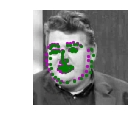

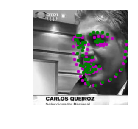

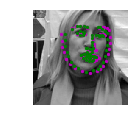

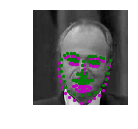

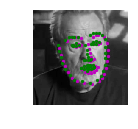

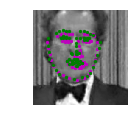

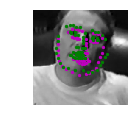

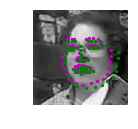

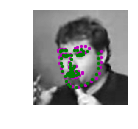

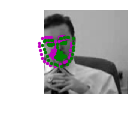

In [18]:
## visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

**Optimizer** -
Adam optimization method has become my reliable choice. I still try SGD with various params and even use schedular to adjust learning rate. The result is not as stable as Adam. SGD is more flexible, customizable, etc. but I haven't figured out a way to make it work better for me yet.

**Loss function** -
I have used MSELoss function before. I wanted to try SmoothL1Loss. It worked fine because our prediction model regression. According to it's SDK doc, "It is less sensitive to outliers than the `MSELoss` and in some cases prevents exploding gradients (e.g. see `Fast R-CNN` paper by Ross Girshick)".


### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:
I tried to copy LeNet CNN architecture first but I was not a getting good result. It was probably because I was using less number of epochs at the time (only 1). Finally, decided to make it more like AlexNet but in my case, I am using 3 Conv layers and 3 FC layers with batch norm and max pool in between the layers. Batch normalization helps with faster and more stable training. Increased layers to maximize accuracy. Added .4 dropout to avoid overfitting.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:
I have heard other students using increased batch size but in my case, either I was getting error or notebook became unresponsive. I started with 1 epoch, then updated it to 10, then to 15, 20, 25, 50 and finally 100. I updated the number of worker to zero but I was getting and so I left the value unchanged (4).

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.32885885 -0.03302248 -0.25088313  0.09100129 -0.12651265]
 [-0.41285616 -0.32731572 -0.13884187  0.02658348  0.14100984]
 [-0.02935746 -0.20272665 -0.04085776  0.03434955 -0.19439124]
 [-0.07027619  0.05585044 -0.10926511 -0.03855523 -0.00422641]
 [-0.02522165 -0.01759276 -0.05169747  0.15681589  0.12088463]]
(5, 5)


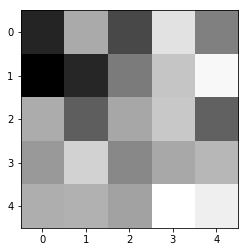

In [5]:
# load the saved model
net = Net()
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# load the net parameters by name
net.load_state_dict(torch.load(model_dir+model_name))

# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy() #!!!!!! DON'T FORGET TO CONVERT TO CPU  !!!!!!!

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### Filter an image to see the effect of a convolutional kernel
---

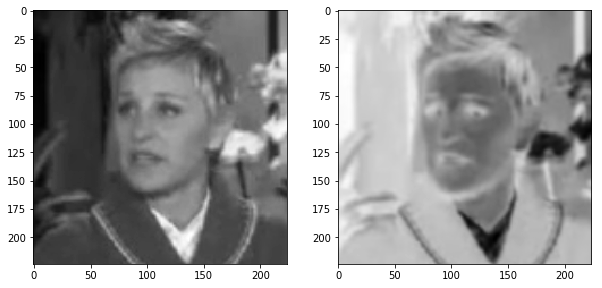

In [35]:
## load in and display any image from the transformed test dataset
import cv2

image = test_images[0].data
image = image.cpu()
image = image.numpy()
image = np.transpose(image, (1, 2, 0))
image = np.squeeze(image)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
plt.subplot(1,2,2)
filtered_image = cv2.filter2D(image, -1, w[0][0])
plt.imshow(filtered_image, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It blurred out noise. Useful to detect simple patterms. It seems to detect vertical edges.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!